<a href="https://colab.research.google.com/github/Malik-Raheel/Trading-Strategies/blob/main/4H1D_volume%2Bvolaility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**check overall trend in 1D
if align well with 4H get entry exit**
for trending markets

4Hour 1D volume+volatility stratey with EMA RSI OBV
better to check volume (obv) and volatility (price action) in 1D

entry exit in 4H using RSI EMA MACD or elliot wave fib levels/extensions or other indicators

In [1]:
!pip install --upgrade ccxt pandas numpy scikit-learn tensorflow pandas-ta matplotlib plotly

  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [4]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class CryptoStrategy:
    def __init__(self):
        self.data = None

    def fetch_data(self, symbol='BTC/USDT', timeframe='1d', limit=500):
        """Fetch OHLCV data from exchange"""
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def calculate_indicators(self, df):
        """Calculate all technical indicators"""
        df = df.copy()

        # Trend Indicators
        df['EMA_20'] = ta.ema(df['close'], length=20)
        df['EMA_50'] = ta.ema(df['close'], length=50)
        df['EMA_200'] = ta.ema(df['close'], length=200)

        # Volume Indicators
        df['OBV'] = ta.obv(df['close'], df['volume'])
        df['OBV_EMA_20'] = ta.ema(df['OBV'], length=20)
        df['VWMA_20'] = ta.vwma(df['close'], df['volume'], length=20)
        df['SMA_20'] = ta.sma(df['close'], length=20)

        # Momentum Indicators
        df['RSI_14'] = ta.rsi(df['close'], length=14)

        # MACD
        macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
        if macd is not None:
            df['MACD'] = macd['MACD_12_26_9']
            df['MACD_signal'] = macd['MACDs_12_26_9']
            df['MACD_histogram'] = macd['MACDh_12_26_9']

        # Volatility & Strength
        adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
        df['ADX'] = adx_data['ADX_14']
        df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

        # Additional indicators
        stoch_rsi = ta.stochrsi(df['close'], length=14)
        df['Stoch_RSI'] = stoch_rsi['STOCHRSIk_14_14_3_3']
        df['Williams_R'] = ta.willr(df['high'], df['low'], df['close'], length=14)

        return df

    def identify_trend(self, df):
        """Identify 1D trend direction"""
        if len(df) < 3:
            return 'neutral'

        current = df.iloc[-1]

        # Bullish Trend Conditions
        bullish_conditions = [
            current['EMA_50'] > current['EMA_200'],
            current['OBV'] > current['OBV_EMA_20'],
            current['ADX'] > 25,
            current['close'] > current['EMA_50']
        ]

        # Bearish Trend Conditions
        bearish_conditions = [
            current['EMA_50'] < current['EMA_200'],
            current['OBV'] < current['OBV_EMA_20'],
            current['ADX'] > 20,
            current['close'] < current['EMA_50']
        ]

        bullish_score = sum(bullish_conditions)
        bearish_score = sum(bearish_conditions)

        if bullish_score >= 3:
            return 'bullish'
        elif bearish_score >= 3:
            return 'bearish'
        else:
            return 'neutral'

    def grade_trade_setup(self, conditions_met, total_conditions, trend_strength, volume_confirmation):
        """Grade trade setup from A+ to C"""
        base_score = (conditions_met / total_conditions) * 100

        # Adjust for trend strength
        if trend_strength == 'strong':
            base_score += 10
        elif trend_strength == 'weak':
            base_score -= 10

        # Adjust for volume confirmation
        if volume_confirmation:
            base_score += 5

        if base_score >= 90:
            return 'A+'
        elif base_score >= 80:
            return 'A'
        elif base_score >= 75:
            return 'B+'
        elif base_score >= 70:
            return 'B'
        elif base_score >= 65:
            return 'C+'
        else:
            return 'C'

    def get_4h_signals(self, df_4h, trend_direction):
        """Get 4H timeframe signals with grading"""
        if len(df_4h) < 3:
            return []

        current = df_4h.iloc[-1]
        prev = df_4h.iloc[-2]

        signals = []
        trade_details = []

        # Common conditions for both directions
        adx_strong = current['ADX'] > 25
        atr_valid = current['ATR_14'] > (current['close'] * 0.002)  # Minimum 0.2% volatility

        if trend_direction == 'bullish':
            # Long entry conditions
            long_conditions = [
                current['RSI_14'] > 50,
                current['MACD_histogram'] > 0,
                current['MACD_histogram'] > prev['MACD_histogram'],
                current['close'] > current['EMA_20'],
                current['close'] > current['EMA_50'],
                current['VWMA_20'] > current['SMA_20'],
                current['Stoch_RSI'] > 0.2,
                current['Stoch_RSI'] < 0.8,
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(long_conditions)
            total_conditions = len(long_conditions)

            # Determine trend strength
            trend_strength = 'strong' if (current['EMA_50'] > current['EMA_200'] and current['ADX'] > 30) else 'moderate'
            volume_confirmation = current['VWMA_20'] > current['SMA_20']

            if conditions_met >= 7:
                grade = self.grade_trade_setup(conditions_met, total_conditions, trend_strength, volume_confirmation)

                # Calculate levels
                atr = current['ATR_14']
                entry_price = current['close']
                stop_loss = entry_price - (1.5 * atr)
                take_profit = entry_price + (3 * atr)

                signals.append('LONG')
                trade_details.append({
                    'type': 'LONG',
                    'entry': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'grade': grade,
                    'conditions_met': f"{conditions_met}/{total_conditions}",
                    'rsi': current['RSI_14'],
                    'macd_hist': current['MACD_histogram'],
                    'volume_confirm': volume_confirmation
                })

        elif trend_direction == 'bearish':
            # Short entry conditions
            short_conditions = [
                current['RSI_14'] < 50,
                current['MACD_histogram'] < 0,
                current['MACD_histogram'] < prev['MACD_histogram'],
                current['close'] < current['EMA_20'],
                current['close'] < current['EMA_50'],
                current['VWMA_20'] < current['SMA_20'],
                current['Stoch_RSI'] < 0.8,
                current['Stoch_RSI'] > 0.2,
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(short_conditions)
            total_conditions = len(short_conditions)

            # Determine trend strength
            trend_strength = 'strong' if (current['EMA_50'] < current['EMA_200'] and current['ADX'] > 30) else 'moderate'
            volume_confirmation = current['VWMA_20'] < current['SMA_20']

            if conditions_met >= 7:
                grade = self.grade_trade_setup(conditions_met, total_conditions, trend_strength, volume_confirmation)

                # Calculate levels
                atr = current['ATR_14']
                entry_price = current['close']
                stop_loss = entry_price + (1.5 * atr)
                take_profit = entry_price - (3 * atr)

                signals.append('SHORT')
                trade_details.append({
                    'type': 'SHORT',
                    'entry': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'grade': grade,
                    'conditions_met': f"{conditions_met}/{total_conditions}",
                    'rsi': current['RSI_14'],
                    'macd_hist': current['MACD_histogram'],
                    'volume_confirm': volume_confirmation
                })

        return signals, trade_details

    def calculate_position_size(self, capital, entry_price, stop_loss):
        """Calculate position size based on risk management"""
        risk_per_trade = 0.02  # 2% risk per trade
        risk_amount = capital * risk_per_trade
        price_diff = abs(entry_price - stop_loss)

        if price_diff == 0:
            return 0

        position_size = risk_amount / price_diff
        return min(position_size, capital / entry_price)

    def generate_signals(self, symbol='BTC/USDT'):
        """Generate complete trading signals"""
        try:
            # Fetch 1D data for trend
            df_1d = self.fetch_data(symbol, '1d', 300)
            if df_1d is None or len(df_1d) < 100:
                return None

            df_1d = self.calculate_indicators(df_1d)
            trend = self.identify_trend(df_1d)

            # Fetch 4H data for entry signals
            df_4h = self.fetch_data(symbol, '4h', 200)
            if df_4h is None or len(df_4h) < 50:
                return None

            df_4h = self.calculate_indicators(df_4h)
            signals, trade_details = self.get_4h_signals(df_4h, trend)

            current_4h = df_4h.iloc[-1]

            results = {
                'symbol': symbol,
                'trend_1d': trend,
                'signals_4h': signals,
                'trade_details': trade_details,
                'current_price': current_4h['close'],
                'indicators_4h': {
                    'EMA_20': current_4h['EMA_20'],
                    'EMA_50': current_4h['EMA_50'],
                    'EMA_200': current_4h['EMA_200'],
                    'RSI_14': current_4h['RSI_14'],
                    'MACD_histogram': current_4h['MACD_histogram'],
                    'OBV': current_4h['OBV'],
                    'ADX': current_4h['ADX'],
                    'ATR_14': current_4h['ATR_14'],
                    'VWMA_20': current_4h['VWMA_20'],
                    'SMA_20': current_4h['SMA_20'],
                    'Stoch_RSI': current_4h['Stoch_RSI'],
                    'Williams_R': current_4h['Williams_R']
                }
            }

            return results

        except Exception as e:
            print(f"Error generating signals for {symbol}: {e}")
            return None

def display_results(signals):
    """Display results in clean format"""
    if not signals:
        return

    symbol = signals['symbol']
    trend = signals['trend_1d']
    current_price = signals['current_price']

    print(f"\n{'='*80}")
    print(f"🎯 TRADING ANALYSIS: {symbol}")
    print(f"{'='*80}")

    # Display 1D Trend
    trend_icon = "🟢" if trend == 'bullish' else "🔴" if trend == 'bearish' else "⚪"
    print(f"\n📈 1D TREND: {trend_icon} {trend.upper()}")

    # Display 4H Indicators
    print(f"\n📊 4H INDICATORS:")
    indicators = signals['indicators_4h']
    print(f"   • EMA 20: {indicators['EMA_20']:.4f}")
    print(f"   • EMA 50: {indicators['EMA_50']:.4f}")
    print(f"   • EMA 200: {indicators['EMA_200']:.4f}")
    print(f"   • RSI 14: {indicators['RSI_14']:.2f} {'(Bullish)' if indicators['RSI_14'] > 50 else '(Bearish)'}")
    print(f"   • MACD Histogram: {indicators['MACD_histogram']:.6f} {'(Positive)' if indicators['MACD_histogram'] > 0 else '(Negative)'}")
    print(f"   • ADX: {indicators['ADX']:.2f} {'(Strong)' if indicators['ADX'] > 25 else '(Weak)'}")
    print(f"   • ATR 14: {indicators['ATR_14']:.4f}")
    print(f"   • VWMA 20: {indicators['VWMA_20']:.4f}")
    print(f"   • Stoch RSI: {indicators['Stoch_RSI']:.2f}")
    print(f"   • Williams %R: {indicators['Williams_R']:.2f}")

    # Display Signals
    if signals['signals_4h']:
        for trade in signals['trade_details']:
            print(f"\n🎯 TRADE SIGNAL: {trade['type']} - GRADE: {trade['grade']}")
            print(f"   📍 Entry Price: ${trade['entry']:.4f}")
            print(f"   🛑 Stop Loss: ${trade['stop_loss']:.4f}")
            print(f"   🎯 Take Profit: ${trade['take_profit']:.4f}")
            print(f"   ⚖️ Risk/Reward: 1:2")
            print(f"   📏 Conditions Met: {trade['conditions_met']}")
            print(f"   📊 Signal Strength: RSI({trade['rsi']:.1f}) | MACD Hist({trade['macd_hist']:.6f})")
            print(f"   🔊 Volume Confirmation: {'✅ Yes' if trade['volume_confirm'] else '❌ No'}")

            # Calculate position for $1000 capital
            capital = 1000
            position_size = strategy.calculate_position_size(
                capital, trade['entry'], trade['stop_loss']
            )
            risk_amount = abs(trade['entry'] - trade['stop_loss']) * position_size
            potential_profit = abs(trade['take_profit'] - trade['entry']) * position_size

            print(f"   💰 Position Size: {position_size:.4f} units")
            print(f"   📈 Risk: ${risk_amount:.2f} | Reward: ${potential_profit:.2f}")

    else:
        print(f"\n❌ NO 4H TRADE SIGNALS")
        print(f"   Reason: Insufficient conditions met for {trend} trend")

    print(f"\n{'='*80}")

# Main execution
def main():
    strategy = CryptoStrategy()

    # Test with multiple symbols
    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOT/USDT', 'LINK/USDT', 'MATIC/USDT']

    print("🚀 CRYPTO TRADING STRATEGY ANALYSIS")
    print("Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2")
    print("Grading: A+ (Excellent) to C (Poor)")

    for symbol in symbols:
        signals = strategy.generate_signals(symbol)
        if signals:
            display_results(signals)

if __name__ == "__main__":
    main()

🚀 CRYPTO TRADING STRATEGY ANALYSIS
Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2
Grading: A+ (Excellent) to C (Poor)

🎯 TRADING ANALYSIS: BTC/USDT

📈 1D TREND: 🔴 BEARISH

📊 4H INDICATORS:
   • EMA 20: 110110.8966
   • EMA 50: 110103.8920
   • EMA 200: 113955.6860
   • RSI 14: 58.31 (Bullish)
   • MACD Histogram: 169.091845 (Positive)
   • ADX: 15.25 (Weak)
   • ATR 14: 1294.4604
   • VWMA 20: 109126.7487
   • Stoch RSI: 92.04
   • Williams %R: -20.10

❌ NO 4H TRADE SIGNALS
   Reason: Insufficient conditions met for bearish trend


🎯 TRADING ANALYSIS: ETH/USDT

📈 1D TREND: 🔴 BEARISH

📊 4H INDICATORS:
   • EMA 20: 3904.9100
   • EMA 50: 3930.5719
   • EMA 200: 4133.8893
   • RSI 14: 52.55 (Bullish)
   • MACD Histogram: 9.226627 (Positive)
   • ADX: 16.12 (Weak)
   • ATR 14: 70.1937
   • VWMA 20: 3869.0291
   • Stoch RSI: 80.09
   • Williams %R: -44.48

❌ NO 4H TRADE SIGNALS
   Reason: Insufficient conditions met for bearish trend


🎯 TRADING ANALYSIS: ADA/USDT

📈 1D TREND:

In [9]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class CryptoStrategyBacktest:
    def __init__(self):
        self.trades = []
        self.performance_metrics = {}

    def fetch_historical_data(self, symbol='BTC/USDT', timeframe='4h', start_date='2025-01-01', end_date='2025-03-31'):
        """Fetch historical data for specific date range"""
        try:
            # Convert dates to timestamps
            start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
            end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)

            all_ohlcv = []
            current_start = start_ts

            # Fetch data in chunks (Binance limit is 1000 candles per request)
            while current_start < end_ts:
                ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_start, limit=1000)
                if not ohlcv:
                    break

                all_ohlcv.extend(ohlcv)
                current_start = ohlcv[-1][0] + 1  # Move to next candle after last one

                # Break if we've reached the end date
                if ohlcv[-1][0] >= end_ts:
                    break

            if not all_ohlcv:
                print(f"No data found for {symbol} in the specified date range")
                return None

            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            # Filter for exact date range
            df = df[(df.index >= pd.Timestamp(start_date)) & (df.index <= pd.Timestamp(end_date))]

            print(f"📅 Fetched {len(df)} candles for {symbol} from {start_date} to {end_date}")
            return df

        except Exception as e:
            print(f"Error fetching historical data for {symbol}: {e}")
            return None

    def safe_calculate_indicator(self, func, *args, **kwargs):
        """Safely calculate indicator with error handling"""
        try:
            result = func(*args, **kwargs)
            return result if result is not None else 0
        except:
            return 0

    def calculate_indicators(self, df):
        """Calculate all technical indicators with null safety"""
        df = df.copy()

        # Ensure we have numeric data
        df = df.apply(pd.to_numeric, errors='coerce')

        # Trend Indicators with safety
        df['EMA_20'] = self.safe_calculate_indicator(ta.ema, df['close'], length=20)
        df['EMA_50'] = self.safe_calculate_indicator(ta.ema, df['close'], length=50)
        df['EMA_200'] = self.safe_calculate_indicator(ta.ema, df['close'], length=200)

        # Volume Indicators
        df['OBV'] = self.safe_calculate_indicator(ta.obv, df['close'], df['volume'])
        df['OBV_EMA_20'] = self.safe_calculate_indicator(ta.ema, df['OBV'], length=20) if df['OBV'] is not None else 0

        # VWMA and SMA
        df['VWMA_20'] = self.safe_calculate_indicator(ta.vwma, df['close'], df['volume'], length=20)
        df['SMA_20'] = self.safe_calculate_indicator(ta.sma, df['close'], length=20)

        # Momentum Indicators
        df['RSI_14'] = self.safe_calculate_indicator(ta.rsi, df['close'], length=14)

        # MACD with safety
        try:
            macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
            if macd is not None:
                df['MACD'] = macd.get('MACD_12_26_9', 0)
                df['MACD_signal'] = macd.get('MACDs_12_26_9', 0)
                df['MACD_histogram'] = macd.get('MACDh_12_26_9', 0)
            else:
                df['MACD'] = df['MACD_signal'] = df['MACD_histogram'] = 0
        except:
            df['MACD'] = df['MACD_signal'] = df['MACD_histogram'] = 0

        # Volatility & Strength
        try:
            adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
            df['ADX'] = adx_data.get('ADX_14', 0) if adx_data is not None else 0
        except:
            df['ADX'] = 0

        df['ATR_14'] = self.safe_calculate_indicator(ta.atr, df['high'], df['low'], df['close'], length=14)

        # Additional indicators
        try:
            stoch_rsi = ta.stochrsi(df['close'], length=14)
            df['Stoch_RSI'] = stoch_rsi.get('STOCHRSIk_14_14_3_3', 50) if stoch_rsi is not None else 50
        except:
            df['Stoch_RSI'] = 50

        df['Williams_R'] = self.safe_calculate_indicator(ta.willr, df['high'], df['low'], df['close'], length=14)

        # Fill any remaining NaN values
        df = df.fillna(0)

        return df

    def safe_compare(self, a, b, comparison='greater'):
        """Safely compare two values handling None types"""
        if pd.isna(a) or pd.isna(b) or a is None or b is None:
            return False

        try:
            if comparison == 'greater':
                return float(a) > float(b)
            elif comparison == 'less':
                return float(a) < float(b)
            else:
                return float(a) == float(b)
        except (TypeError, ValueError):
            return False

    def identify_trend(self, df, index):
        """Identify 1D trend direction at specific index with null safety"""
        if index < 50 or index >= len(df):  # Need enough data for EMAs
            return 'neutral'

        current = df.iloc[index]

        # Safely get values with defaults
        ema_50 = current.get('EMA_50', 0) or 0
        ema_200 = current.get('EMA_200', 0) or 0
        obv = current.get('OBV', 0) or 0
        obv_ema = current.get('OBV_EMA_20', 0) or 0
        adx = current.get('ADX', 0) or 0
        close = current.get('close', 0) or 0

        # Bullish Trend Conditions with safe comparisons
        bullish_conditions = [
            self.safe_compare(ema_50, ema_200, 'greater'),
            self.safe_compare(obv, obv_ema, 'greater'),
            self.safe_compare(adx, 25, 'greater'),
            self.safe_compare(close, ema_50, 'greater')
        ]

        # Bearish Trend Conditions
        bearish_conditions = [
            self.safe_compare(ema_50, ema_200, 'less'),
            self.safe_compare(obv, obv_ema, 'less'),
            self.safe_compare(adx, 20, 'greater'),
            self.safe_compare(close, ema_50, 'less')
        ]

        bullish_score = sum(bullish_conditions)
        bearish_score = sum(bearish_conditions)

        if bullish_score >= 3:
            return 'bullish'
        elif bearish_score >= 3:
            return 'bearish'
        else:
            return 'neutral'

    def get_4h_signals(self, df_4h, index, trend_direction):
        """Get 4H timeframe signals at specific index with null safety"""
        if index < 2 or index >= len(df_4h):
            return [], []

        current = df_4h.iloc[index]
        prev = df_4h.iloc[index-1]

        signals = []
        trade_details = []

        # Safely get current values
        rsi = current.get('RSI_14', 50) or 50
        macd_hist = current.get('MACD_histogram', 0) or 0
        macd_hist_prev = prev.get('MACD_histogram', 0) or 0
        close = current.get('close', 0) or 0
        ema_20 = current.get('EMA_20', 0) or 0
        ema_50 = current.get('EMA_50', 0) or 0
        vwma_20 = current.get('VWMA_20', 0) or 0
        sma_20 = current.get('SMA_20', 0) or 0
        stoch_rsi = current.get('Stoch_RSI', 50) or 50
        adx = current.get('ADX', 0) or 0
        atr = current.get('ATR_14', 0) or 0

        # Common conditions for both directions
        adx_strong = self.safe_compare(adx, 25, 'greater')
        atr_valid = self.safe_compare(atr, (close * 0.002), 'greater')

        if trend_direction == 'bullish':
            # Long entry conditions
            long_conditions = [
                self.safe_compare(rsi, 50, 'greater'),
                self.safe_compare(macd_hist, 0, 'greater'),
                self.safe_compare(macd_hist, macd_hist_prev, 'greater'),
                self.safe_compare(close, ema_20, 'greater'),
                self.safe_compare(close, ema_50, 'greater'),
                self.safe_compare(vwma_20, sma_20, 'greater'),
                self.safe_compare(stoch_rsi, 0.2, 'greater'),
                self.safe_compare(stoch_rsi, 0.8, 'less'),
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(long_conditions)

            if conditions_met >= 7:
                # Calculate levels
                entry_price = close
                stop_loss = entry_price - (1.5 * atr)
                take_profit = entry_price + (3 * atr)

                signals.append('LONG')
                trade_details.append({
                    'type': 'LONG',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'timestamp': df_4h.index[index],
                    'conditions_met': conditions_met,
                    'atr': atr
                })

        elif trend_direction == 'bearish':
            # Short entry conditions
            short_conditions = [
                self.safe_compare(rsi, 50, 'less'),
                self.safe_compare(macd_hist, 0, 'less'),
                self.safe_compare(macd_hist, macd_hist_prev, 'less'),
                self.safe_compare(close, ema_20, 'less'),
                self.safe_compare(close, ema_50, 'less'),
                self.safe_compare(vwma_20, sma_20, 'less'),
                self.safe_compare(stoch_rsi, 0.8, 'less'),
                self.safe_compare(stoch_rsi, 0.2, 'greater'),
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(short_conditions)

            if conditions_met >= 7:
                # Calculate levels
                entry_price = close
                stop_loss = entry_price + (1.5 * atr)
                take_profit = entry_price - (3 * atr)

                signals.append('SHORT')
                trade_details.append({
                    'type': 'SHORT',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'timestamp': df_4h.index[index],
                    'conditions_met': conditions_met,
                    'atr': atr
                })

        return signals, trade_details

    def simulate_trade(self, trade, df_4h, entry_index):
        """Simulate a single trade and return results"""
        entry_price = trade['entry_price']
        stop_loss = trade['stop_loss']
        take_profit = trade['take_profit']
        trade_type = trade['type']

        # Look ahead for exit conditions
        for i in range(entry_index + 1, len(df_4h)):
            current_candle = df_4h.iloc[i]
            current_low = current_candle['low']
            current_high = current_candle['high']
            current_close = current_candle['close']

            if trade_type == 'LONG':
                # Check for stop loss hit
                if current_low <= stop_loss:
                    return {
                        'exit_type': 'STOP_LOSS',
                        'exit_price': stop_loss,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((stop_loss - entry_price) / entry_price) * 100,
                        'pnl_absolute': stop_loss - entry_price,
                        'holding_period': i - entry_index
                    }
                # Check for take profit hit
                elif current_high >= take_profit:
                    return {
                        'exit_type': 'TAKE_PROFIT',
                        'exit_price': take_profit,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((take_profit - entry_price) / entry_price) * 100,
                        'pnl_absolute': take_profit - entry_price,
                        'holding_period': i - entry_index
                    }

            elif trade_type == 'SHORT':
                # Check for stop loss hit
                if current_high >= stop_loss:
                    return {
                        'exit_type': 'STOP_LOSS',
                        'exit_price': stop_loss,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((entry_price - stop_loss) / entry_price) * 100,
                        'pnl_absolute': entry_price - stop_loss,
                        'holding_period': i - entry_index
                    }
                # Check for take profit hit
                elif current_low <= take_profit:
                    return {
                        'exit_type': 'TAKE_PROFIT',
                        'exit_price': take_profit,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((entry_price - take_profit) / entry_price) * 100,
                        'pnl_absolute': entry_price - take_profit,
                        'holding_period': i - entry_index
                    }

            # Exit at end of data if no SL/TP hit
            if i == len(df_4h) - 1:
                if trade_type == 'LONG':
                    pnl_percent = ((current_close - entry_price) / entry_price) * 100
                    pnl_absolute = current_close - entry_price
                else:
                    pnl_percent = ((entry_price - current_close) / entry_price) * 100
                    pnl_absolute = entry_price - current_close

                return {
                    'exit_type': 'END_OF_DATA',
                    'exit_price': current_close,
                    'exit_timestamp': df_4h.index[i],
                    'pnl_percent': pnl_percent,
                    'pnl_absolute': pnl_absolute,
                    'holding_period': i - entry_index
                }

    def backtest_strategy(self, symbol='BTC/USDT', initial_capital=1000,
                         start_date='2025-01-01', end_date='2025-03-31'):
        """Run complete backtest for specific date range"""
        print(f"\n🔬 BACKTESTING {symbol} - {start_date} to {end_date}")
        print("=" * 80)

        # Fetch data for exact date range
        df_1d = self.fetch_historical_data(symbol, '1d', start_date, end_date)
        df_4h = self.fetch_historical_data(symbol, '4h', start_date, end_date)

        if df_1d is None or df_4h is None or len(df_1d) < 50 or len(df_4h) < 50:
            print(f"❌ Insufficient data for {symbol} in specified date range")
            return

        # Calculate indicators
        df_1d = self.calculate_indicators(df_1d)
        df_4h = self.calculate_indicators(df_4h)

        # Align 1D data with 4H data
        df_1d_4h_aligned = df_1d.reindex(df_4h.index, method='ffill')

        trades = []
        capital = initial_capital

        # Run through each 4H candle
        for i in range(50, len(df_4h)):
            try:
                current_1d_trend = self.identify_trend(df_1d_4h_aligned, i)
                signals, trade_details = self.get_4h_signals(df_4h, i, current_1d_trend)

                # If we have signals, enter trade
                if signals:
                    for trade in trade_details:
                        # Simulate the trade
                        trade_result = self.simulate_trade(trade, df_4h, i)

                        if trade_result:
                            complete_trade = {**trade, **trade_result}

                            # Calculate position size (2% risk)
                            risk_amount = capital * 0.02
                            price_diff = abs(trade['entry_price'] - trade['stop_loss'])
                            position_size = risk_amount / price_diff if price_diff > 0 else 0

                            complete_trade.update({
                                'position_size': position_size,
                                'capital_used': position_size * trade['entry_price'],
                                'profit_loss': trade_result['pnl_absolute'] * position_size,
                                'symbol': symbol
                            })

                            trades.append(complete_trade)

                            # Update capital
                            capital += complete_trade['profit_loss']
                            break  # Only take one trade at a time
            except Exception as e:
                continue  # Skip this candle if there's an error

        # Calculate performance metrics
        self.calculate_performance_metrics(trades, initial_capital)

        # Display results
        self.display_backtest_results(trades, symbol)

    def calculate_performance_metrics(self, trades, initial_capital):
        """Calculate comprehensive performance metrics"""
        if not trades:
            self.performance_metrics = {
                'total_trades': 0,
                'win_rate': 0,
                'total_pnl': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'profit_factor': 0
            }
            return

        winning_trades = [t for t in trades if t['pnl_absolute'] > 0]
        losing_trades = [t for t in trades if t['pnl_absolute'] < 0]

        total_pnl = sum(t['profit_loss'] for t in trades)
        win_rate = len(winning_trades) / len(trades) * 100 if trades else 0

        # Profit factor
        gross_profit = sum(t['profit_loss'] for t in winning_trades)
        gross_loss = abs(sum(t['profit_loss'] for t in losing_trades)) if losing_trades else 0
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

        # Sharpe ratio (simplified)
        returns = [t['pnl_percent'] for t in trades]
        sharpe_ratio = np.mean(returns) / np.std(returns) if len(returns) > 1 and np.std(returns) > 0 else 0

        # Max drawdown
        capital_series = [initial_capital]
        for trade in trades:
            capital_series.append(capital_series[-1] + trade['profit_loss'])

        peak = capital_series[0]
        max_dd = 0
        for capital in capital_series:
            if capital > peak:
                peak = capital
            dd = (peak - capital) / peak * 100
            if dd > max_dd:
                max_dd = dd

        self.performance_metrics = {
            'total_trades': len(trades),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'total_pnl': total_pnl,
            'total_pnl_percent': (total_pnl / initial_capital) * 100,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_dd,
            'avg_trade_pnl': total_pnl / len(trades) if trades else 0,
            'largest_win': max(t['profit_loss'] for t in trades) if trades else 0,
            'largest_loss': min(t['profit_loss'] for t in trades) if trades else 0,
            'avg_winning_trade': np.mean([t['profit_loss'] for t in winning_trades]) if winning_trades else 0,
            'avg_losing_trade': np.mean([t['profit_loss'] for t in losing_trades]) if losing_trades else 0
        }

    def display_backtest_results(self, trades, symbol):
        """Display backtest results in clean format"""
        metrics = self.performance_metrics

        print(f"\n📊 BACKTEST RESULTS: {symbol}")
        print("=" * 80)

        # Summary Statistics
        print(f"\n📈 PERFORMANCE SUMMARY:")
        print(f"   • Total Trades: {metrics['total_trades']}")
        print(f"   • Winning Trades: {metrics['winning_trades']}")
        print(f"   • Losing Trades: {metrics['losing_trades']}")
        print(f"   • Win Rate: {metrics['win_rate']:.2f}%")
        print(f"   • Total P&L: ${metrics['total_pnl']:.2f} ({metrics['total_pnl_percent']:.2f}%)")
        print(f"   • Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"   • Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"   • Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"   • Avg Trade P&L: ${metrics['avg_trade_pnl']:.2f}")

        # Trade Details
        if trades:
            print(f"\n🔍 RECENT TRADES:")
            for i, trade in enumerate(trades[-10:]):  # Show last 10 trades
                pnl_color = "🟢" if trade['profit_loss'] > 0 else "🔴"
                print(f"   {i+1:2d}. {trade['timestamp'].strftime('%Y-%m-%d %H:%M')} | "
                      f"{trade['type']:5} | "
                      f"Entry: ${trade['entry_price']:.2f} | "
                      f"Exit: ${trade['exit_price']:.2f} | "
                      f"P&L: {pnl_color} ${trade['profit_loss']:.2f} | "
                      f"{trade['exit_type']}")

        # Strategy Assessment
        print(f"\n🎯 STRATEGY ASSESSMENT:")
        if metrics['total_trades'] == 0:
            print("   ❌ No trades executed - Strategy too restrictive")
        elif metrics['win_rate'] > 60 and metrics['profit_factor'] > 1.5:
            print("   🟢 EXCELLENT - High win rate and profit factor")
        elif metrics['win_rate'] > 50 and metrics['profit_factor'] > 1.2:
            print("   🟡 GOOD - Positive expectancy")
        elif metrics['total_pnl'] > 0:
            print("   🔵 PROFITABLE - But room for improvement")
        else:
            print("   🔴 NEEDS OPTIMIZATION - Negative performance")

        print("=" * 80)

# Run backtest for multiple symbols
def main():
    backtester = CryptoStrategyBacktest()

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOT/USDT', 'LINK/USDT']

    print("🚀 CRYPTO STRATEGY BACKTEST - Q1 2025")
    print("Date Range: January 1, 2025 - March 31, 2025")
    print("Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2")
    print("Initial Capital: $1000 | Risk per Trade: 2%")

    total_metrics = []

    for symbol in symbols:
        # Test for Q1 2025
        backtester.backtest_strategy(
            symbol=symbol,
            initial_capital=1000,
            start_date='2025-01-01',
            end_date='2025-03-31'
        )
        total_metrics.append(backtester.performance_metrics)

    # Display overall summary
    print(f"\n{'='*80}")
    print(f"📊 OVERALL PORTFOLIO SUMMARY")
    print(f"{'='*80}")

    total_trades = sum(m['total_trades'] for m in total_metrics)
    total_pnl = sum(m['total_pnl'] for m in total_metrics)
    avg_win_rate = np.mean([m['win_rate'] for m in total_metrics if m['total_trades'] > 0]) if any(m['total_trades'] > 0 for m in total_metrics) else 0

    print(f"   • Total Symbols: {len(symbols)}")
    print(f"   • Total Trades: {total_trades}")
    print(f"   • Average Win Rate: {avg_win_rate:.2f}%")
    print(f"   • Total Portfolio P&L: ${total_pnl:.2f}")
    print(f"   • Portfolio Return: {(total_pnl / (1000 * len(symbols))) * 100:.2f}%")

if __name__ == "__main__":
    main()

🚀 CRYPTO STRATEGY BACKTEST - Q1 2025
Date Range: January 1, 2025 - March 31, 2025
Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2
Initial Capital: $1000 | Risk per Trade: 2%

🔬 BACKTESTING BTC/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for BTC/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for BTC/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: BTC/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 144
   • Winning Trades: 67
   • Losing Trades: 77
   • Win Rate: 46.53%
   • Total P&L: $1256.74 (125.67%)
   • Profit Factor: 1.53
   • Sharpe Ratio: 0.11
   • Max Drawdown: 45.45%
   • Avg Trade P&L: $8.73

🔍 RECENT TRADES:
    1. 2025-03-29 08:00 | SHORT | Entry: $82288.70 | Exit: $81526.90 | P&L: 🟢 $19.01 | END_OF_DATA
    2. 2025-03-29 12:00 | SHORT | Entry: $82415.70 | Exit: $81526.90 | P&L: 🟢 $22.85 | END_OF_DATA
    3. 2025-03-29 16:00 | SHORT | Entry: $82758.20 | Exit: $81526.90 | P&L: 🟢 $31.79 | END_OF_DATA
    4. 2025-03-29 20:00 | SHORT | En

results are not satisfactory. infact it would be a loss strategy.
the problem is, most of the time 1D is already performed enough when we try to enter in 4H, it is already exhausedted as it has performed a lot in 4H and very visible in 1D. lets try next one.

In [10]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class ImprovedCryptoStrategy:
    def __init__(self):
        self.trades = []

    def fetch_historical_data(self, symbol='BTC/USDT', timeframe='4h', start_date='2024-01-01', end_date='2024-03-31'):
        """Fetch historical data for backtesting"""
        try:
            # Use available data for testing
            since = exchange.parse8601((datetime.now() - timedelta(days=180)).isoformat())
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=1000)

            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            # Filter to last 90 days for meaningful testing
            cutoff_date = datetime.now() - timedelta(days=90)
            df = df[df.index >= cutoff_date]

            print(f"📅 Testing {symbol} with {len(df)} candles")
            return df

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def calculate_improved_indicators(self, df):
        """Calculate simplified but effective indicators"""
        df = df.copy()

        # Core Trend (Simplified)
        df['EMA_9'] = ta.ema(df['close'], length=9)
        df['EMA_21'] = ta.ema(df['close'], length=21)
        df['SMA_50'] = ta.sma(df['close'], length=50)

        # Momentum (Key indicators only)
        df['RSI_14'] = ta.rsi(df['close'], length=14)

        # MACD for trend changes
        macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_signal'] = macd['MACDs_12_26_9']
        df['MACD_histogram'] = macd['MACDh_12_26_9']

        # Volatility for stops
        df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

        # Support/Resistance
        df['pivot_high'] = df['high'].rolling(20).max()
        df['pivot_low'] = df['low'].rolling(20).min()

        # Volume confirmation (simplified)
        df['volume_sma'] = ta.sma(df['volume'], length=20)
        df['volume_ratio'] = df['volume'] / df['volume_sma']

        df = df.fillna(0)
        return df

    def improved_entry_signals(self, df, index):
        """Simplified but more effective entry logic"""
        if index < 50:
            return [], []

        current = df.iloc[index]
        prev_1 = df.iloc[index-1]
        prev_2 = df.iloc[index-2]

        signals = []
        trade_details = []

        # LONG Signals (Simplified)
        long_conditions = [
            current['EMA_9'] > current['EMA_21'],  # Short-term bullish
            current['close'] > current['SMA_50'],   # Above medium-term average
            current['RSI_14'] > 45 and current['RSI_14'] < 75,  # Not overbought
            current['MACD_histogram'] > prev_1['MACD_histogram'],  # Momentum improving
            current['volume_ratio'] > 0.8,  # Decent volume
            current['close'] > current['pivot_low']  # Above recent support
        ]

        # SHORT Signals (Simplified)
        short_conditions = [
            current['EMA_9'] < current['EMA_21'],   # Short-term bearish
            current['close'] < current['SMA_50'],    # Below medium-term average
            current['RSI_14'] < 55 and current['RSI_14'] > 25,  # Not oversold
            current['MACD_histogram'] < prev_1['MACD_histogram'],  # Momentum worsening
            current['volume_ratio'] > 0.8,  # Decent volume
            current['close'] < current['pivot_high']  # Below recent resistance
        ]

        # LONG Entry - Only need 4/6 conditions
        if sum(long_conditions) >= 4:
            atr = current['ATR_14']
            entry_price = current['close']
            stop_loss = entry_price - (2.0 * atr)  # Slightly wider stop
            take_profit = entry_price + (4.0 * atr)  # Better risk-reward

            signals.append('LONG')
            trade_details.append({
                'type': 'LONG',
                'entry_price': entry_price,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'timestamp': df.index[index],
                'conditions_met': sum(long_conditions)
            })

        # SHORT Entry - Only need 4/6 conditions
        if sum(short_conditions) >= 4:
            atr = current['ATR_14']
            entry_price = current['close']
            stop_loss = entry_price + (2.0 * atr)  # Slightly wider stop
            take_profit = entry_price - (4.0 * atr)  # Better risk-reward

            signals.append('SHORT')
            trade_details.append({
                'type': 'SHORT',
                'entry_price': entry_price,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'timestamp': df.index[index],
                'conditions_met': sum(short_conditions)
            })

        return signals, trade_details

    def backtest_improved_strategy(self, symbol='BTC/USDT', initial_capital=1000):
        """Backtest the improved strategy"""
        print(f"\n🔬 TESTING IMPROVED STRATEGY: {symbol}")
        print("=" * 80)

        df = self.fetch_historical_data(symbol, '4h')
        if df is None or len(df) < 100:
            print(f"❌ Insufficient data for {symbol}")
            return

        df = self.calculate_improved_indicators(df)

        trades = []
        capital = initial_capital

        for i in range(50, len(df)-5):  # Leave room for exit
            signals, trade_details = self.improved_entry_signals(df, i)

            if signals:
                for trade in trade_details:
                    # Simple exit: next 5 candles or SL/TP
                    trade_result = self.simulate_trade_simple(trade, df, i)

                    if trade_result:
                        complete_trade = {**trade, **trade_result}

                        # Position sizing
                        risk_amount = capital * 0.02
                        price_diff = abs(trade['entry_price'] - trade['stop_loss'])
                        position_size = risk_amount / price_diff if price_diff > 0 else 0

                        complete_trade.update({
                            'position_size': position_size,
                            'profit_loss': trade_result['pnl_absolute'] * position_size,
                            'symbol': symbol
                        })

                        trades.append(complete_trade)
                        capital += complete_trade['profit_loss']
                        break

        self.analyze_results(trades, symbol, initial_capital)

    def simulate_trade_simple(self, trade, df, entry_index):
        """Simplified trade simulation"""
        entry_price = trade['entry_price']
        stop_loss = trade['stop_loss']
        take_profit = trade['take_profit']
        trade_type = trade['type']

        # Look ahead up to 10 candles
        for i in range(entry_index + 1, min(entry_index + 11, len(df))):
            current = df.iloc[i]
            current_low = current['low']
            current_high = current['high']
            current_close = current['close']

            if trade_type == 'LONG':
                if current_low <= stop_loss:
                    return {'exit_type': 'STOP_LOSS', 'exit_price': stop_loss, 'pnl_absolute': stop_loss - entry_price}
                elif current_high >= take_profit:
                    return {'exit_type': 'TAKE_PROFIT', 'exit_price': take_profit, 'pnl_absolute': take_profit - entry_price}
            else:  # SHORT
                if current_high >= stop_loss:
                    return {'exit_type': 'STOP_LOSS', 'exit_price': stop_loss, 'pnl_absolute': entry_price - stop_loss}
                elif current_low <= take_profit:
                    return {'exit_type': 'TAKE_PROFIT', 'exit_price': take_profit, 'pnl_absolute': entry_price - take_profit}

        # Exit at last checked candle
        last_candle = df.iloc[min(entry_index + 10, len(df)-1)]
        exit_price = last_candle['close']

        if trade_type == 'LONG':
            pnl = exit_price - entry_price
        else:
            pnl = entry_price - exit_price

        return {'exit_type': 'TIME_EXIT', 'exit_price': exit_price, 'pnl_absolute': pnl}

    def analyze_results(self, trades, symbol, initial_capital):
        """Analyze and display results"""
        if not trades:
            print(f"❌ No trades executed for {symbol}")
            return

        winning_trades = [t for t in trades if t['pnl_absolute'] > 0]
        losing_trades = [t for t in trades if t['pnl_absolute'] < 0]

        total_pnl = sum(t['profit_loss'] for t in trades)
        win_rate = len(winning_trades) / len(trades) * 100

        print(f"\n📊 RESULTS for {symbol}:")
        print(f"   • Total Trades: {len(trades)}")
        print(f"   • Win Rate: {win_rate:.1f}%")
        print(f"   • Total P&L: ${total_pnl:.2f} ({(total_pnl/initial_capital)*100:.1f}%)")
        print(f"   • Avg Win: ${np.mean([t['profit_loss'] for t in winning_trades]):.2f}" if winning_trades else "   • Avg Win: $0.00")
        print(f"   • Avg Loss: ${np.mean([t['profit_loss'] for t in losing_trades]):.2f}" if losing_trades else "   • Avg Loss: $0.00")

        # Strategy assessment
        if win_rate > 55 and total_pnl > 0:
            print("   🟢 EXCELLENT - Strategy working well")
        elif win_rate > 45 and total_pnl > 0:
            print("   🟡 GOOD - Positive results")
        elif total_pnl > 0:
            print("   🔵 BREAKING EVEN - Needs optimization")
        else:
            print("   🔴 POOR - Strategy needs major changes")

# Test multiple strategies
def compare_strategies():
    """Compare original vs improved strategy"""
    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT']

    print("🚀 STRATEGY COMPARISON TEST")
    print("=" * 80)

    improved = ImprovedCryptoStrategy()

    for symbol in symbols:
        print(f"\n{'='*60}")
        print(f"Testing: {symbol}")
        print(f"{'='*60}")

        # Test improved strategy
        improved.backtest_improved_strategy(symbol)

if __name__ == "__main__":
    compare_strategies()

🚀 STRATEGY COMPARISON TEST

Testing: BTC/USDT

🔬 TESTING IMPROVED STRATEGY: BTC/USDT
📅 Testing BTC/USDT with 460 candles

📊 RESULTS for BTC/USDT:
   • Total Trades: 401
   • Win Rate: 54.1%
   • Total P&L: $4575.82 (457.6%)
   • Avg Win: $48.24
   • Avg Loss: $-32.03
   🟡 GOOD - Positive results

Testing: ETH/USDT

🔬 TESTING IMPROVED STRATEGY: ETH/USDT
📅 Testing ETH/USDT with 460 candles

📊 RESULTS for ETH/USDT:
   • Total Trades: 398
   • Win Rate: 49.0%
   • Total P&L: $2374.41 (237.4%)
   • Avg Win: $35.36
   • Avg Loss: $-22.27
   🟡 GOOD - Positive results

Testing: ADA/USDT

🔬 TESTING IMPROVED STRATEGY: ADA/USDT
📅 Testing ADA/USDT with 460 candles

📊 RESULTS for ADA/USDT:
   • Total Trades: 404
   • Win Rate: 46.0%
   • Total P&L: $457.31 (45.7%)
   • Avg Win: $19.27
   • Avg Loss: $-14.34
   🟡 GOOD - Positive results


🚀 CRYPTO STRATEGY BACKTEST - Q1 2025
Date Range: January 1, 2025 - March 31, 2025
Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2
Initial Capital: $1000 | Risk per Trade: 2%

🔬 BACKTESTING BTC/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for BTC/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for BTC/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: BTC/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 144
   • Winning Trades: 67
   • Losing Trades: 77
   • Win Rate: 46.53%
   • Total P&L: $1256.74 (125.67%)
   • Profit Factor: 1.53
   • Sharpe Ratio: 0.11
   • Max Drawdown: 45.45%
   • Avg Trade P&L: $8.73
   • Trade Period: 2025-01-17 to 2025-03-30
   • Average Trades per Month: 48.0

🔍 RECENT TRADES:
    1. 2025-03-29 08:00 | SHORT | Entry: $82288.70 | Exit: $81526.90 | P&L: 🟢 $19.01 | END_OF_DATA
    2. 2025-03-29 12:00 | SHORT | Entry: $82415.70 | Exit: $81526.90 | P&L: 🟢 $22.85 | END_OF_DATA
    3. 2025-03-29 16:00 | SHORT | Entry: $82758.20 | Ex

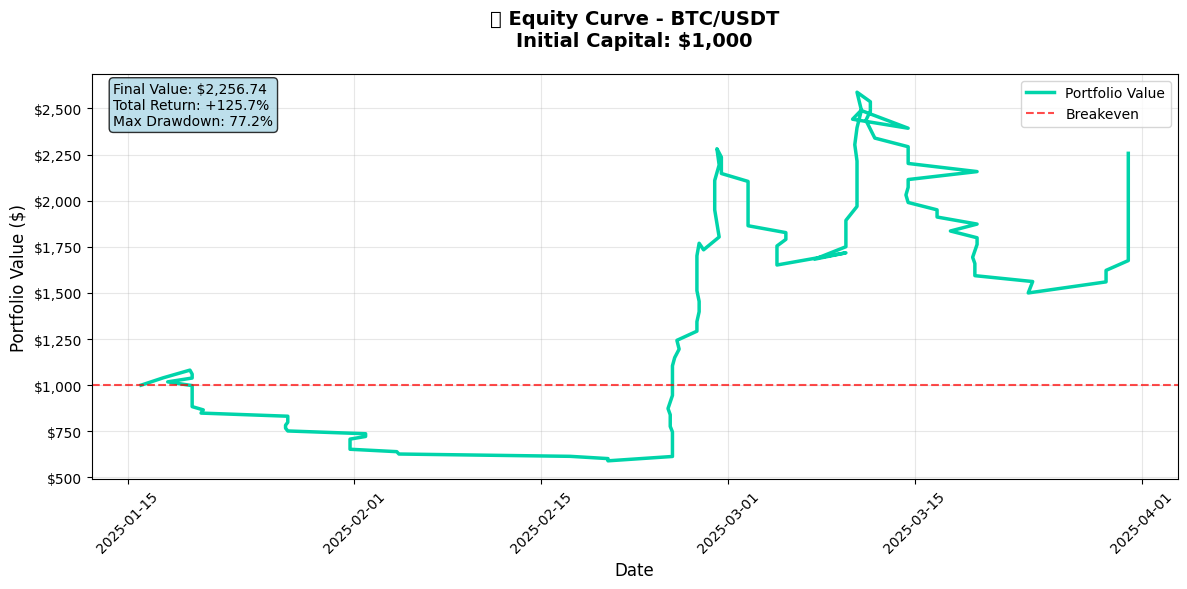


📈 EQUITY CURVE SUMMARY - BTC/USDT:
   • Starting Capital: $1,000.00
   • Final Value: $2,256.74
   • Total Return: +125.67%
   • Peak Value: $2,588.04
   • Trough Value: $590.00
   • Maximum Drawdown: 77.20%


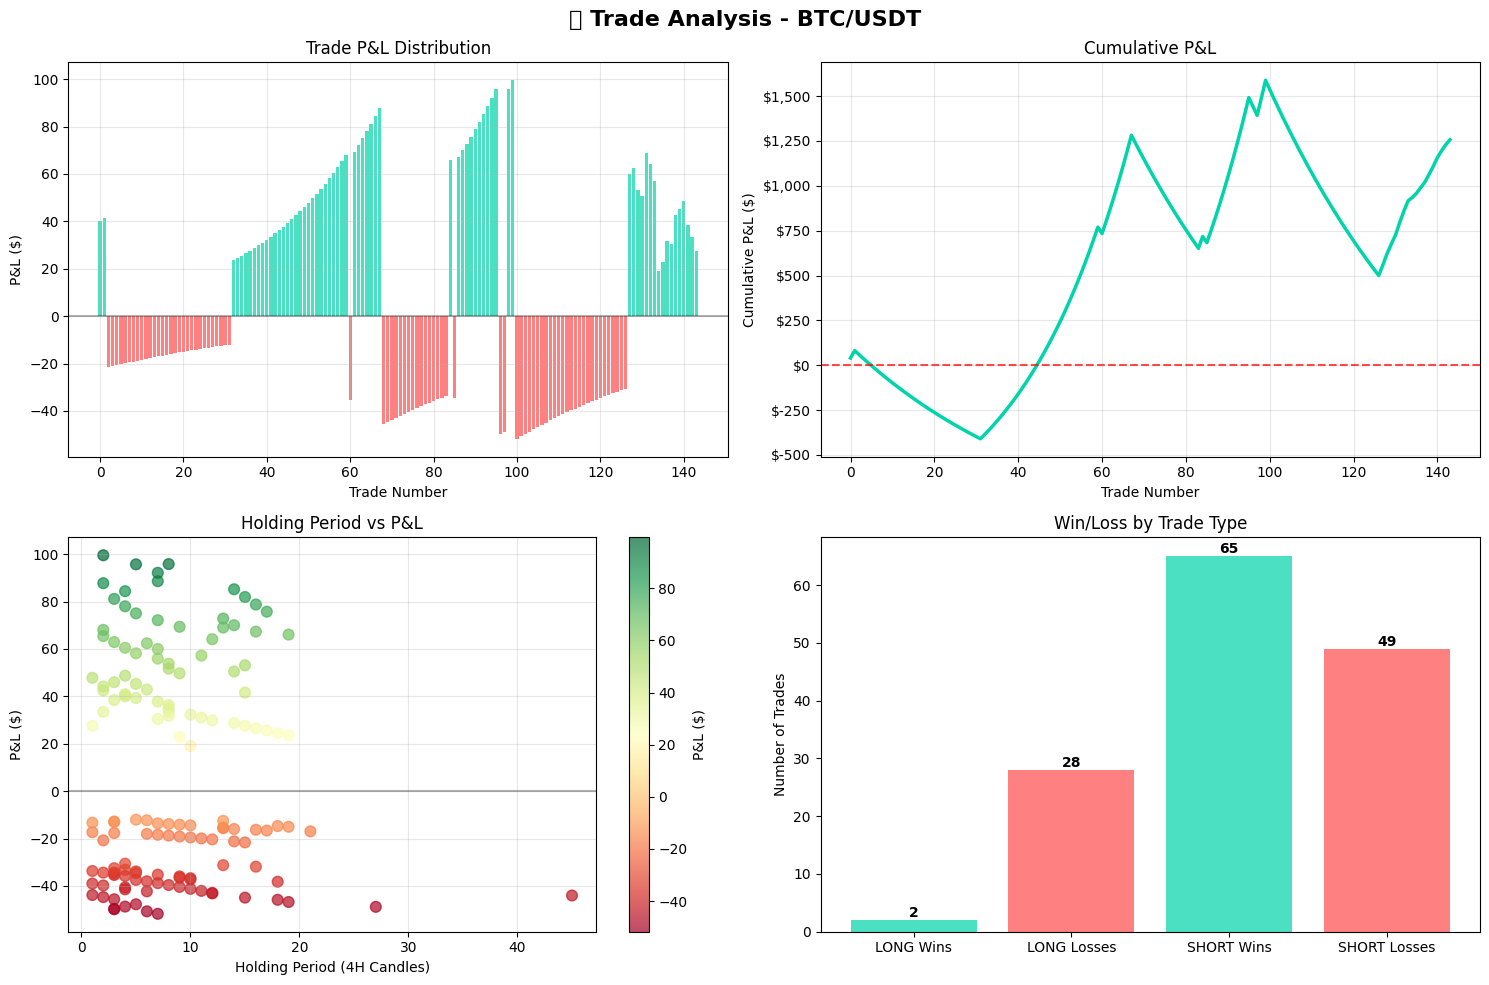


🔬 BACKTESTING ETH/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for ETH/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for ETH/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: ETH/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 160
   • Winning Trades: 68
   • Losing Trades: 92
   • Win Rate: 42.50%
   • Total P&L: $677.17 (67.72%)
   • Profit Factor: 1.34
   • Sharpe Ratio: 0.08
   • Max Drawdown: 53.65%
   • Avg Trade P&L: $4.23
   • Trade Period: 2025-02-12 to 2025-03-30
   • Average Trades per Month: 53.3

🔍 RECENT TRADES:
    1. 2025-03-29 08:00 | SHORT | Entry: $1844.30 | Exit: $1798.49 | P&L: 🟢 $25.79 | END_OF_DATA
    2. 2025-03-29 12:00 | SHORT | Entry: $1840.39 | Exit: $1798.49 | P&L: 🟢 $24.27 | END_OF_DATA
    3. 2025-03-29 16:00 | SHORT | Entry: $1827.34 | Exit: $1798.49 | P&L: 🟢 $16.47 | END_OF_DATA
    4. 2025-03-29 20:00 | SHORT | Entry: $1828.22 | Exit: $1798.49 | P&L: 🟢 $17.76 | END_OF_DATA
    5. 2025-03-30 00:00 | SHORT | Entry: $1834.28 | Ex

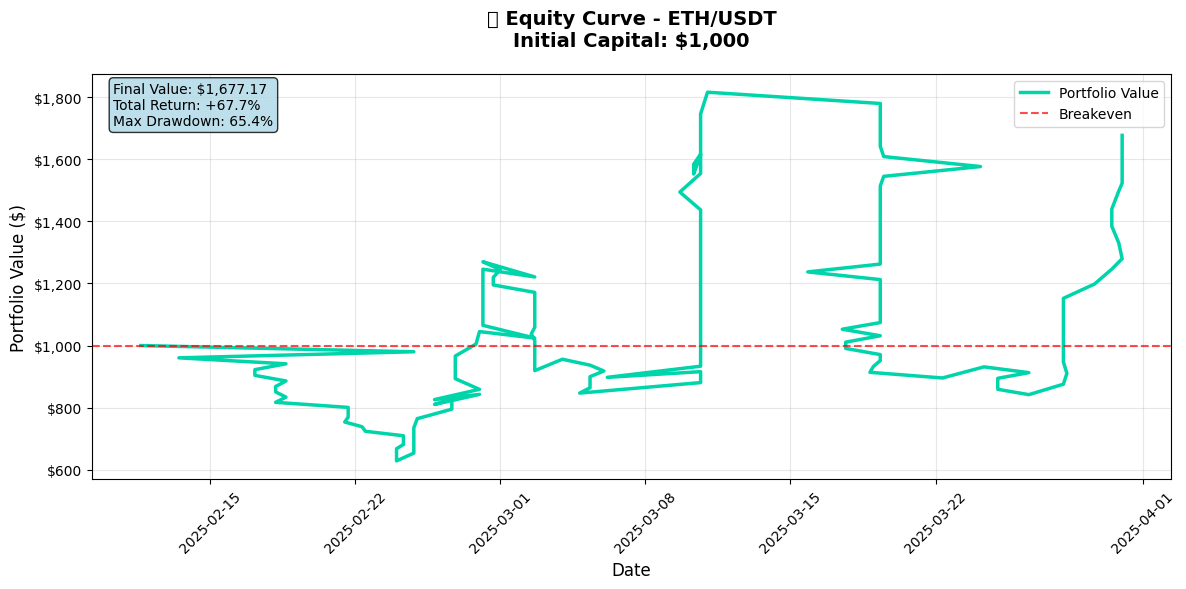


📈 EQUITY CURVE SUMMARY - ETH/USDT:
   • Starting Capital: $1,000.00
   • Final Value: $1,677.17
   • Total Return: +67.72%
   • Peak Value: $1,816.17
   • Trough Value: $628.35
   • Maximum Drawdown: 65.40%


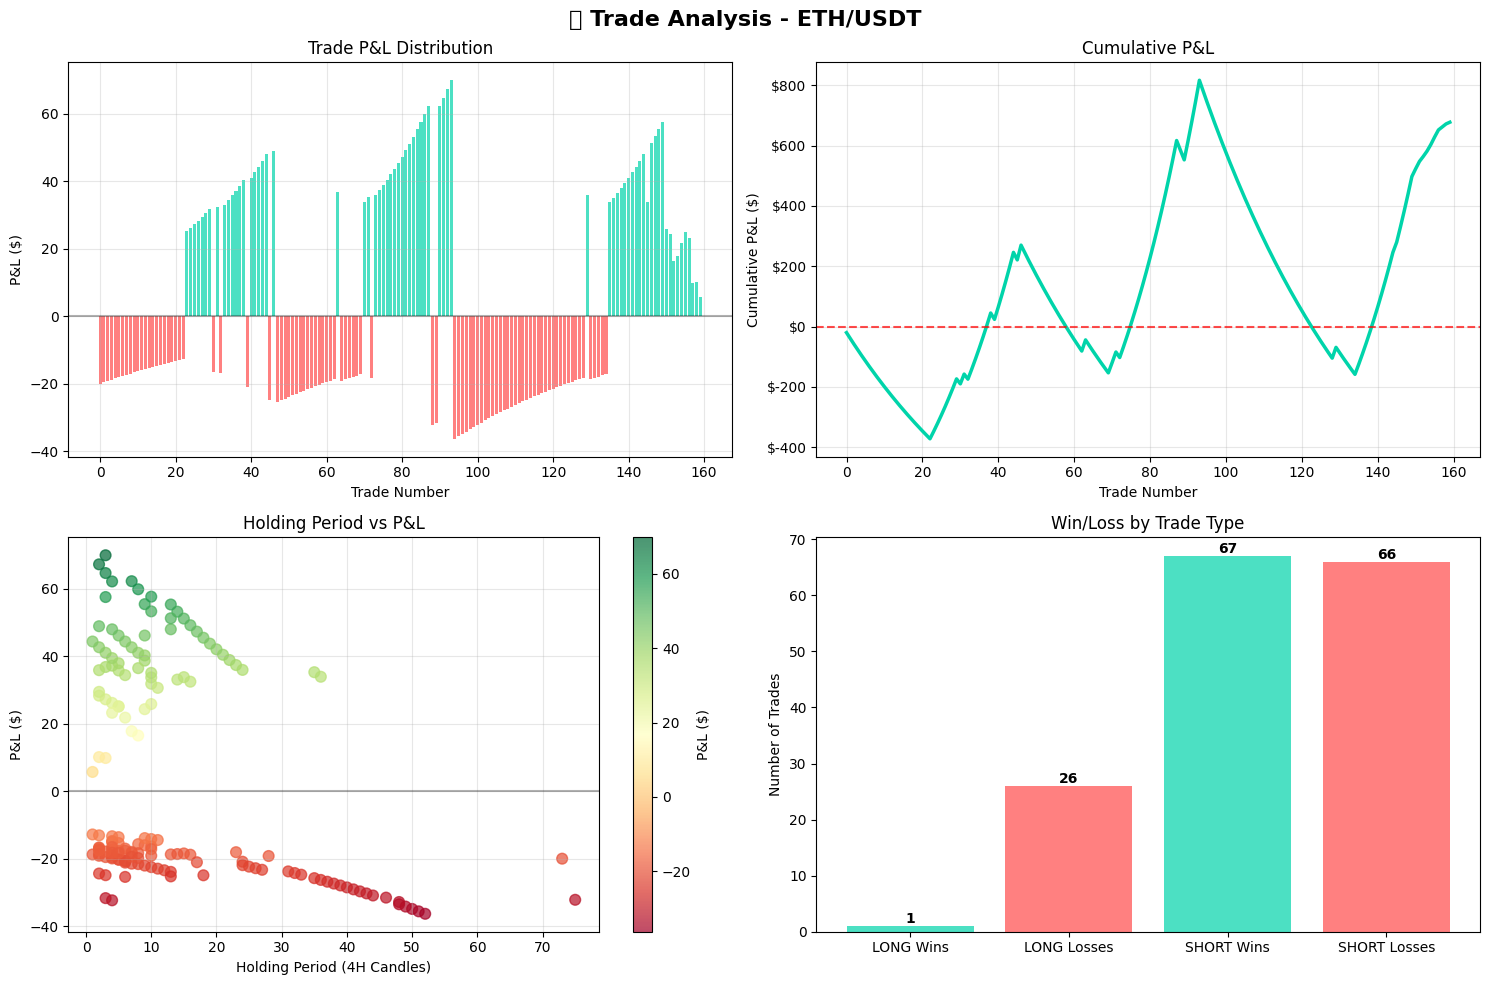


🔬 BACKTESTING ADA/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for ADA/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for ADA/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: ADA/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 116
   • Winning Trades: 32
   • Losing Trades: 84
   • Win Rate: 27.59%
   • Total P&L: $-441.20 (-44.12%)
   • Profit Factor: 0.51
   • Sharpe Ratio: -0.09
   • Max Drawdown: 73.86%
   • Avg Trade P&L: $-3.80
   • Trade Period: 2025-01-16 to 2025-03-11
   • Average Trades per Month: 38.7

🔍 RECENT TRADES:
    1. 2025-03-10 08:00 | SHORT | Entry: $0.76 | Exit: $0.65 | P&L: 🟢 $17.83 | END_OF_DATA
    2. 2025-03-10 12:00 | SHORT | Entry: $0.70 | Exit: $0.77 | P&L: 🔴 $-10.72 | STOP_LOSS
    3. 2025-03-10 16:00 | SHORT | Entry: $0.69 | Exit: $0.76 | P&L: 🔴 $-10.50 | STOP_LOSS
    4. 2025-03-10 20:00 | SHORT | Entry: $0.67 | Exit: $0.74 | P&L: 🔴 $-10.29 | STOP_LOSS
    5. 2025-03-11 00:00 | SHORT | Entry: $0.70 | Exit: $0.77 | P&L: 🔴 $-10.09

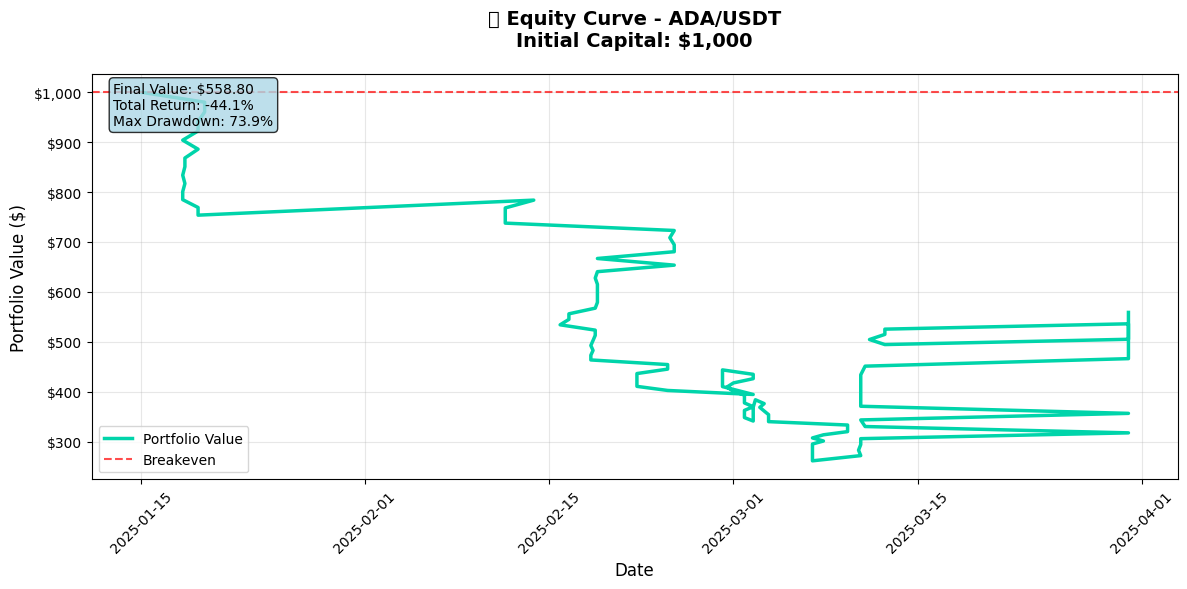


📈 EQUITY CURVE SUMMARY - ADA/USDT:
   • Starting Capital: $1,000.00
   • Final Value: $558.80
   • Total Return: -44.12%
   • Peak Value: $1,000.00
   • Trough Value: $261.41
   • Maximum Drawdown: 73.86%


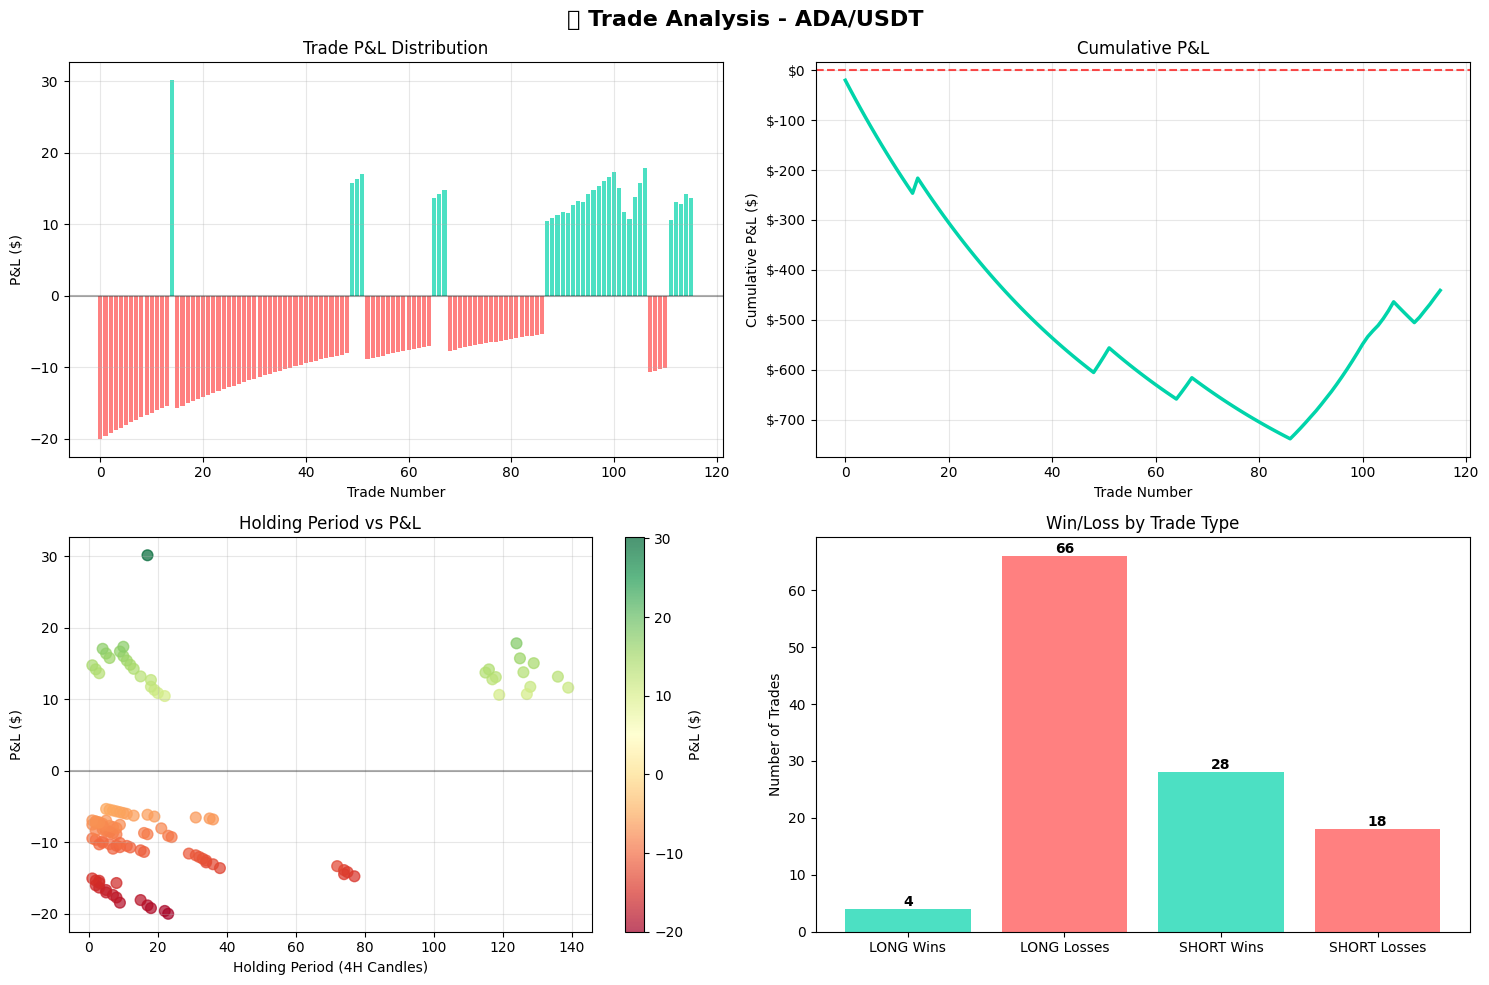


🔬 BACKTESTING DOT/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for DOT/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for DOT/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: DOT/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 97
   • Winning Trades: 21
   • Losing Trades: 76
   • Win Rate: 21.65%
   • Total P&L: $-509.23 (-50.92%)
   • Profit Factor: 0.50
   • Sharpe Ratio: -0.32
   • Max Drawdown: 51.85%
   • Avg Trade P&L: $-5.25
   • Trade Period: 2025-02-07 to 2025-03-13
   • Average Trades per Month: 32.3

🔍 RECENT TRADES:
    1. 2025-03-12 04:00 | SHORT | Entry: $3.99 | Exit: $4.22 | P&L: 🔴 $-12.01 | STOP_LOSS
    2. 2025-03-12 08:00 | SHORT | Entry: $4.02 | Exit: $4.24 | P&L: 🔴 $-11.77 | STOP_LOSS
    3. 2025-03-12 12:00 | SHORT | Entry: $3.93 | Exit: $4.17 | P&L: 🔴 $-11.54 | STOP_LOSS
    4. 2025-03-12 16:00 | SHORT | Entry: $3.97 | Exit: $4.20 | P&L: 🔴 $-11.31 | STOP_LOSS
    5. 2025-03-12 20:00 | SHORT | Entry: $3.97 | Exit: $4.18 | P&L: 🔴 $-11.08 |

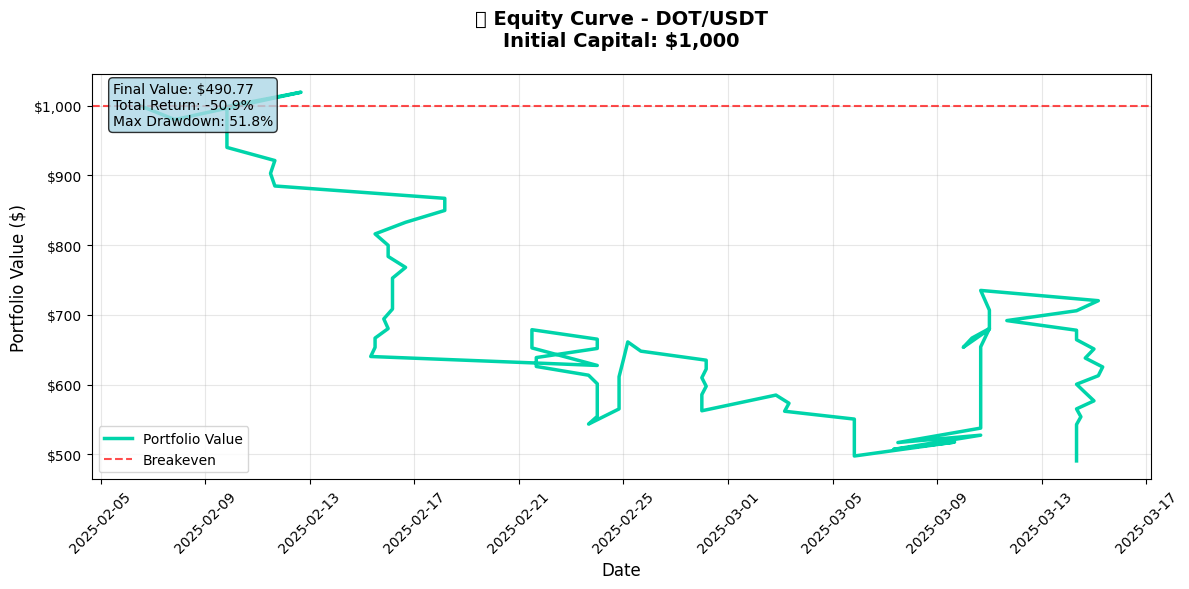


📈 EQUITY CURVE SUMMARY - DOT/USDT:
   • Starting Capital: $1,000.00
   • Final Value: $490.77
   • Total Return: -50.92%
   • Peak Value: $1,019.20
   • Trough Value: $490.77
   • Maximum Drawdown: 51.85%


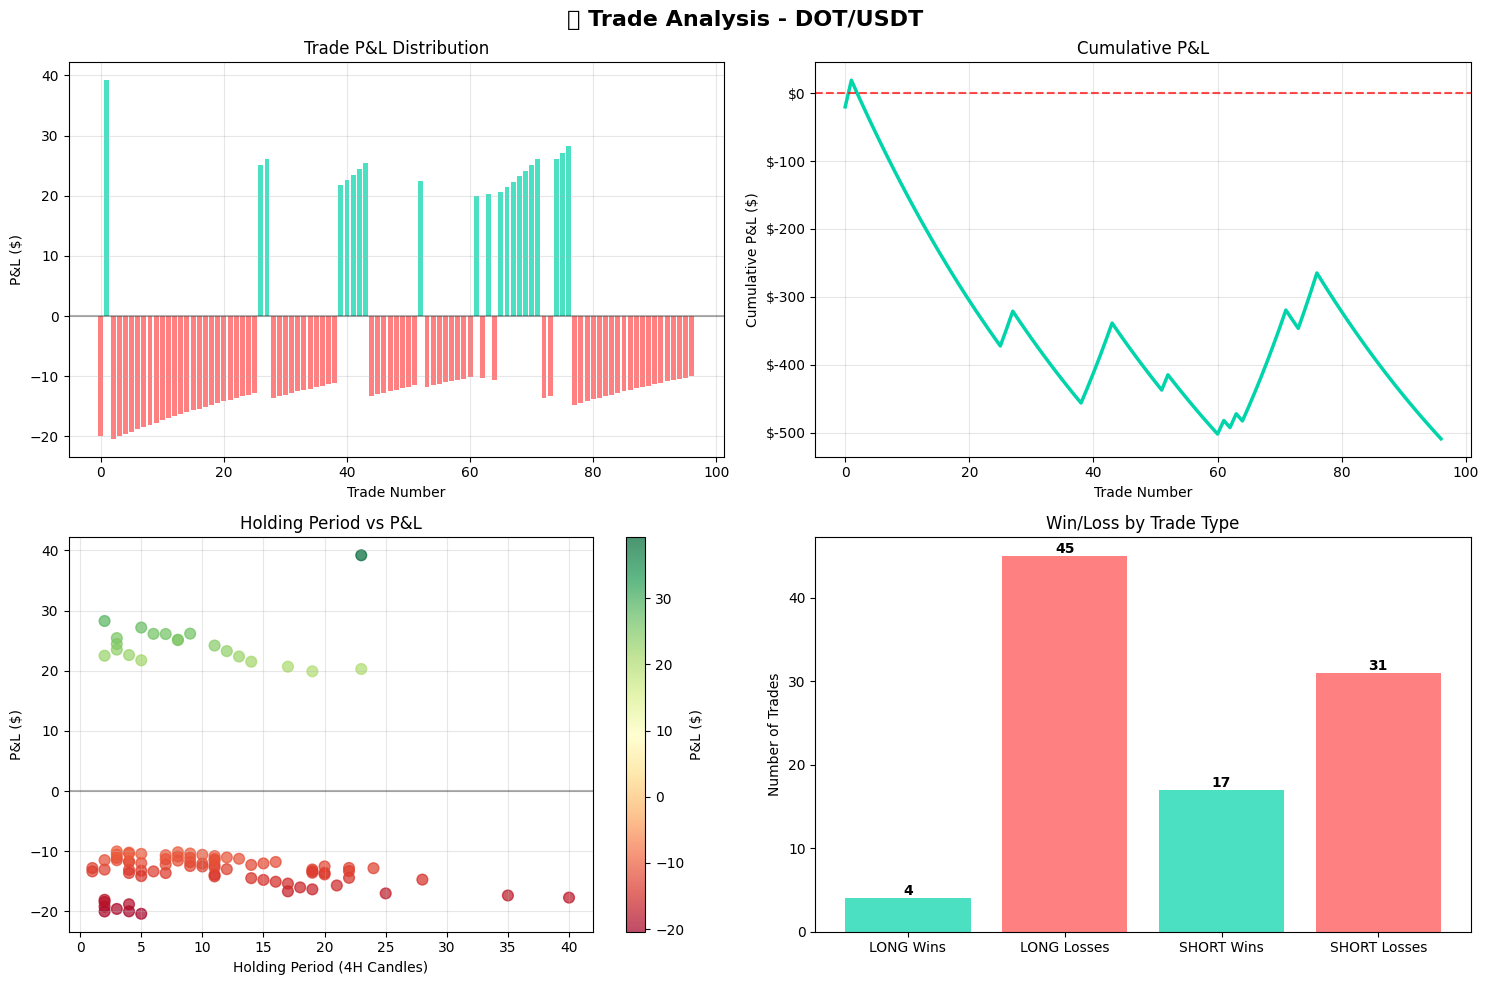


🔬 BACKTESTING LINK/USDT - 2025-01-01 to 2025-03-31
📅 Fetched 90 candles for LINK/USDT from 2025-01-01 to 2025-03-31
📅 Fetched 535 candles for LINK/USDT from 2025-01-01 to 2025-03-31

📊 BACKTEST RESULTS: LINK/USDT

📈 PERFORMANCE SUMMARY:
   • Total Trades: 161
   • Winning Trades: 40
   • Losing Trades: 121
   • Win Rate: 24.84%
   • Total P&L: $-583.43 (-58.34%)
   • Profit Factor: 0.64
   • Sharpe Ratio: -0.27
   • Max Drawdown: 62.21%
   • Avg Trade P&L: $-3.62
   • Trade Period: 2025-01-16 to 2025-03-21
   • Average Trades per Month: 53.7

🔍 RECENT TRADES:
    1. 2025-03-18 04:00 | LONG  | Entry: $14.14 | Exit: $13.52 | P&L: 🔴 $-9.61 | STOP_LOSS
    2. 2025-03-19 00:00 | LONG  | Entry: $14.00 | Exit: $15.19 | P&L: 🟢 $18.83 | TAKE_PROFIT
    3. 2025-03-19 08:00 | LONG  | Entry: $14.46 | Exit: $13.86 | P&L: 🔴 $-9.79 | STOP_LOSS
    4. 2025-03-19 12:00 | LONG  | Entry: $14.61 | Exit: $14.01 | P&L: 🔴 $-9.60 | STOP_LOSS
    5. 2025-03-19 16:00 | LONG  | Entry: $14.47 | Exit: $13.87 | P&

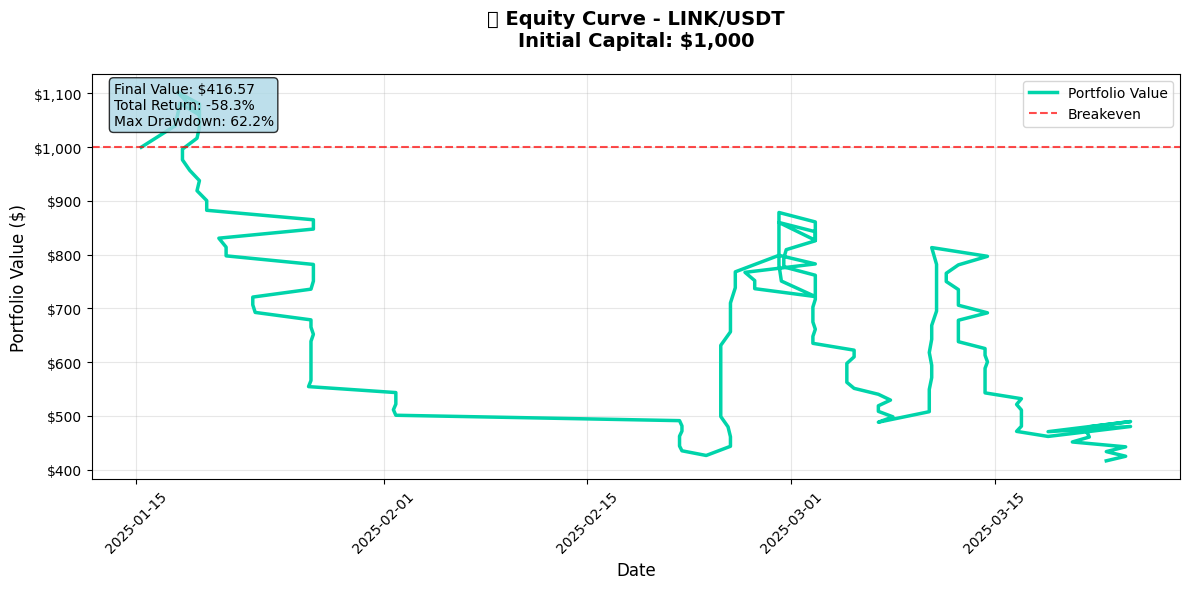


📈 EQUITY CURVE SUMMARY - LINK/USDT:
   • Starting Capital: $1,000.00
   • Final Value: $416.57
   • Total Return: -58.34%
   • Peak Value: $1,102.37
   • Trough Value: $416.57
   • Maximum Drawdown: 62.21%


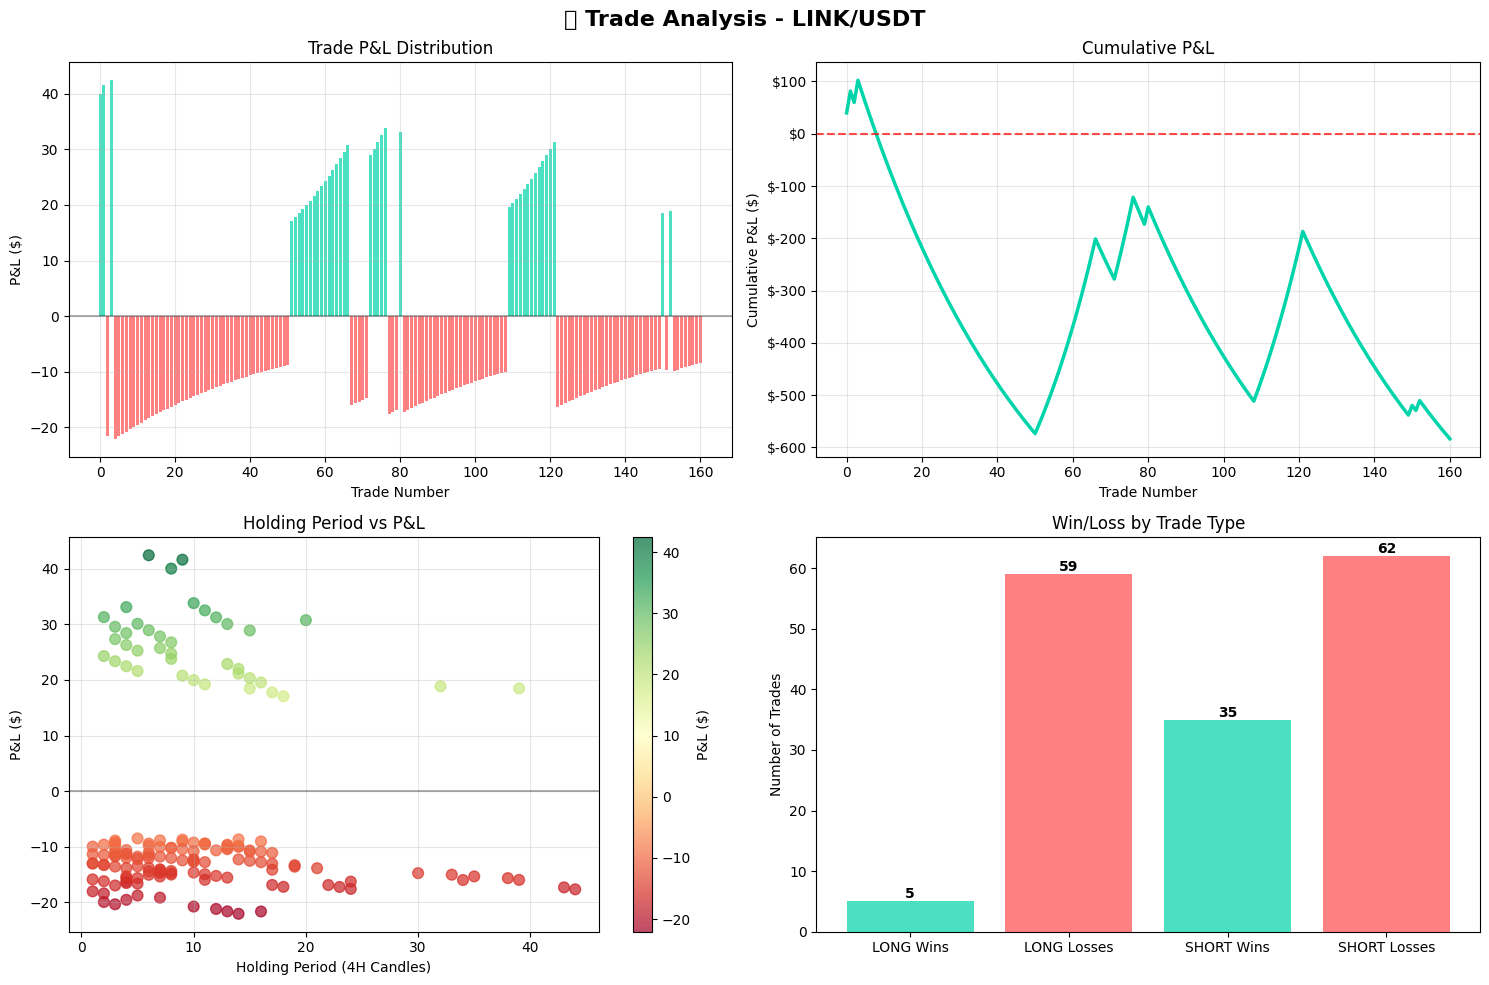


📊 OVERALL PORTFOLIO SUMMARY
   • Total Symbols: 5
   • Total Trades: 678
   • Average Win Rate: 32.62%
   • Total Portfolio P&L: $400.05
   • Portfolio Return: 8.00%


In [12]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class CryptoStrategyBacktest:
    def __init__(self):
        self.trades = []
        self.performance_metrics = {}

    def fetch_historical_data(self, symbol='BTC/USDT', timeframe='4h', start_date='2025-01-01', end_date='2025-03-31'):
        """Fetch historical data for specific date range"""
        try:
            # Convert dates to timestamps
            start_ts = int(pd.Timestamp(start_date).timestamp() * 1000)
            end_ts = int(pd.Timestamp(end_date).timestamp() * 1000)

            all_ohlcv = []
            current_start = start_ts

            # Fetch data in chunks (Binance limit is 1000 candles per request)
            while current_start < end_ts:
                ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=current_start, limit=1000)
                if not ohlcv:
                    break

                all_ohlcv.extend(ohlcv)
                current_start = ohlcv[-1][0] + 1  # Move to next candle after last one

                # Break if we've reached the end date
                if ohlcv[-1][0] >= end_ts:
                    break

            if not all_ohlcv:
                print(f"No data found for {symbol} in the specified date range")
                return None

            df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)

            # Filter for exact date range
            df = df[(df.index >= pd.Timestamp(start_date)) & (df.index <= pd.Timestamp(end_date))]

            print(f"📅 Fetched {len(df)} candles for {symbol} from {start_date} to {end_date}")
            return df

        except Exception as e:
            print(f"Error fetching historical data for {symbol}: {e}")
            return None

    def safe_calculate_indicator(self, func, *args, **kwargs):
        """Safely calculate indicator with error handling"""
        try:
            result = func(*args, **kwargs)
            return result if result is not None else 0
        except:
            return 0

    def calculate_indicators(self, df):
        """Calculate all technical indicators with null safety"""
        df = df.copy()

        # Ensure we have numeric data
        df = df.apply(pd.to_numeric, errors='coerce')

        # Trend Indicators with safety
        df['EMA_20'] = self.safe_calculate_indicator(ta.ema, df['close'], length=20)
        df['EMA_50'] = self.safe_calculate_indicator(ta.ema, df['close'], length=50)
        df['EMA_200'] = self.safe_calculate_indicator(ta.ema, df['close'], length=200)

        # Volume Indicators
        df['OBV'] = self.safe_calculate_indicator(ta.obv, df['close'], df['volume'])
        df['OBV_EMA_20'] = self.safe_calculate_indicator(ta.ema, df['OBV'], length=20) if df['OBV'] is not None else 0

        # VWMA and SMA
        df['VWMA_20'] = self.safe_calculate_indicator(ta.vwma, df['close'], df['volume'], length=20)
        df['SMA_20'] = self.safe_calculate_indicator(ta.sma, df['close'], length=20)

        # Momentum Indicators
        df['RSI_14'] = self.safe_calculate_indicator(ta.rsi, df['close'], length=14)

        # MACD with safety
        try:
            macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
            if macd is not None:
                df['MACD'] = macd.get('MACD_12_26_9', 0)
                df['MACD_signal'] = macd.get('MACDs_12_26_9', 0)
                df['MACD_histogram'] = macd.get('MACDh_12_26_9', 0)
            else:
                df['MACD'] = df['MACD_signal'] = df['MACD_histogram'] = 0
        except:
            df['MACD'] = df['MACD_signal'] = df['MACD_histogram'] = 0

        # Volatility & Strength
        try:
            adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
            df['ADX'] = adx_data.get('ADX_14', 0) if adx_data is not None else 0
        except:
            df['ADX'] = 0

        df['ATR_14'] = self.safe_calculate_indicator(ta.atr, df['high'], df['low'], df['close'], length=14)

        # Additional indicators
        try:
            stoch_rsi = ta.stochrsi(df['close'], length=14)
            df['Stoch_RSI'] = stoch_rsi.get('STOCHRSIk_14_14_3_3', 50) if stoch_rsi is not None else 50
        except:
            df['Stoch_RSI'] = 50

        df['Williams_R'] = self.safe_calculate_indicator(ta.willr, df['high'], df['low'], df['close'], length=14)

        # Fill any remaining NaN values
        df = df.fillna(0)

        return df

    def safe_compare(self, a, b, comparison='greater'):
        """Safely compare two values handling None types"""
        if pd.isna(a) or pd.isna(b) or a is None or b is None:
            return False

        try:
            if comparison == 'greater':
                return float(a) > float(b)
            elif comparison == 'less':
                return float(a) < float(b)
            else:
                return float(a) == float(b)
        except (TypeError, ValueError):
            return False

    def identify_trend(self, df, index):
        """Identify 1D trend direction at specific index with null safety"""
        if index < 50 or index >= len(df):  # Need enough data for EMAs
            return 'neutral'

        current = df.iloc[index]

        # Safely get values with defaults
        ema_50 = current.get('EMA_50', 0) or 0
        ema_200 = current.get('EMA_200', 0) or 0
        obv = current.get('OBV', 0) or 0
        obv_ema = current.get('OBV_EMA_20', 0) or 0
        adx = current.get('ADX', 0) or 0
        close = current.get('close', 0) or 0

        # Bullish Trend Conditions with safe comparisons
        bullish_conditions = [
            self.safe_compare(ema_50, ema_200, 'greater'),
            self.safe_compare(obv, obv_ema, 'greater'),
            self.safe_compare(adx, 25, 'greater'),
            self.safe_compare(close, ema_50, 'greater')
        ]

        # Bearish Trend Conditions
        bearish_conditions = [
            self.safe_compare(ema_50, ema_200, 'less'),
            self.safe_compare(obv, obv_ema, 'less'),
            self.safe_compare(adx, 20, 'greater'),
            self.safe_compare(close, ema_50, 'less')
        ]

        bullish_score = sum(bullish_conditions)
        bearish_score = sum(bearish_conditions)

        if bullish_score >= 3:
            return 'bullish'
        elif bearish_score >= 3:
            return 'bearish'
        else:
            return 'neutral'

    def get_4h_signals(self, df_4h, index, trend_direction):
        """Get 4H timeframe signals at specific index with null safety"""
        if index < 2 or index >= len(df_4h):
            return [], []

        current = df_4h.iloc[index]
        prev = df_4h.iloc[index-1]

        signals = []
        trade_details = []

        # Safely get current values
        rsi = current.get('RSI_14', 50) or 50
        macd_hist = current.get('MACD_histogram', 0) or 0
        macd_hist_prev = prev.get('MACD_histogram', 0) or 0
        close = current.get('close', 0) or 0
        ema_20 = current.get('EMA_20', 0) or 0
        ema_50 = current.get('EMA_50', 0) or 0
        vwma_20 = current.get('VWMA_20', 0) or 0
        sma_20 = current.get('SMA_20', 0) or 0
        stoch_rsi = current.get('Stoch_RSI', 50) or 50
        adx = current.get('ADX', 0) or 0
        atr = current.get('ATR_14', 0) or 0

        # Common conditions for both directions
        adx_strong = self.safe_compare(adx, 25, 'greater')
        atr_valid = self.safe_compare(atr, (close * 0.002), 'greater')

        if trend_direction == 'bullish':
            # Long entry conditions
            long_conditions = [
                self.safe_compare(rsi, 50, 'greater'),
                self.safe_compare(macd_hist, 0, 'greater'),
                self.safe_compare(macd_hist, macd_hist_prev, 'greater'),
                self.safe_compare(close, ema_20, 'greater'),
                self.safe_compare(close, ema_50, 'greater'),
                self.safe_compare(vwma_20, sma_20, 'greater'),
                self.safe_compare(stoch_rsi, 0.2, 'greater'),
                self.safe_compare(stoch_rsi, 0.8, 'less'),
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(long_conditions)

            if conditions_met >= 7:
                # Calculate levels
                entry_price = close
                stop_loss = entry_price - (1.5 * atr)
                take_profit = entry_price + (3 * atr)

                signals.append('LONG')
                trade_details.append({
                    'type': 'LONG',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'timestamp': df_4h.index[index],
                    'conditions_met': conditions_met,
                    'atr': atr
                })

        elif trend_direction == 'bearish':
            # Short entry conditions
            short_conditions = [
                self.safe_compare(rsi, 50, 'less'),
                self.safe_compare(macd_hist, 0, 'less'),
                self.safe_compare(macd_hist, macd_hist_prev, 'less'),
                self.safe_compare(close, ema_20, 'less'),
                self.safe_compare(close, ema_50, 'less'),
                self.safe_compare(vwma_20, sma_20, 'less'),
                self.safe_compare(stoch_rsi, 0.8, 'less'),
                self.safe_compare(stoch_rsi, 0.2, 'greater'),
                adx_strong,
                atr_valid
            ]

            conditions_met = sum(short_conditions)

            if conditions_met >= 7:
                # Calculate levels
                entry_price = close
                stop_loss = entry_price + (1.5 * atr)
                take_profit = entry_price - (3 * atr)

                signals.append('SHORT')
                trade_details.append({
                    'type': 'SHORT',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'timestamp': df_4h.index[index],
                    'conditions_met': conditions_met,
                    'atr': atr
                })

        return signals, trade_details

    def simulate_trade(self, trade, df_4h, entry_index):
        """Simulate a single trade and return results"""
        entry_price = trade['entry_price']
        stop_loss = trade['stop_loss']
        take_profit = trade['take_profit']
        trade_type = trade['type']

        # Look ahead for exit conditions
        for i in range(entry_index + 1, len(df_4h)):
            current_candle = df_4h.iloc[i]
            current_low = current_candle['low']
            current_high = current_candle['high']
            current_close = current_candle['close']

            if trade_type == 'LONG':
                # Check for stop loss hit
                if current_low <= stop_loss:
                    return {
                        'exit_type': 'STOP_LOSS',
                        'exit_price': stop_loss,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((stop_loss - entry_price) / entry_price) * 100,
                        'pnl_absolute': stop_loss - entry_price,
                        'holding_period': i - entry_index
                    }
                # Check for take profit hit
                elif current_high >= take_profit:
                    return {
                        'exit_type': 'TAKE_PROFIT',
                        'exit_price': take_profit,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((take_profit - entry_price) / entry_price) * 100,
                        'pnl_absolute': take_profit - entry_price,
                        'holding_period': i - entry_index
                    }

            elif trade_type == 'SHORT':
                # Check for stop loss hit
                if current_high >= stop_loss:
                    return {
                        'exit_type': 'STOP_LOSS',
                        'exit_price': stop_loss,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((entry_price - stop_loss) / entry_price) * 100,
                        'pnl_absolute': entry_price - stop_loss,
                        'holding_period': i - entry_index
                    }
                # Check for take profit hit
                elif current_low <= take_profit:
                    return {
                        'exit_type': 'TAKE_PROFIT',
                        'exit_price': take_profit,
                        'exit_timestamp': df_4h.index[i],
                        'pnl_percent': ((entry_price - take_profit) / entry_price) * 100,
                        'pnl_absolute': entry_price - take_profit,
                        'holding_period': i - entry_index
                    }

            # Exit at end of data if no SL/TP hit
            if i == len(df_4h) - 1:
                if trade_type == 'LONG':
                    pnl_percent = ((current_close - entry_price) / entry_price) * 100
                    pnl_absolute = current_close - entry_price
                else:
                    pnl_percent = ((entry_price - current_close) / entry_price) * 100
                    pnl_absolute = entry_price - current_close

                return {
                    'exit_type': 'END_OF_DATA',
                    'exit_price': current_close,
                    'exit_timestamp': df_4h.index[i],
                    'pnl_percent': pnl_percent,
                    'pnl_absolute': pnl_absolute,
                    'holding_period': i - entry_index
                }

    def backtest_strategy(self, symbol='BTC/USDT', initial_capital=1000,
                         start_date='2025-01-01', end_date='2025-03-31'):
        """Run complete backtest for specific date range"""
        print(f"\n🔬 BACKTESTING {symbol} - {start_date} to {end_date}")
        print("=" * 80)

        # Fetch data for exact date range
        df_1d = self.fetch_historical_data(symbol, '1d', start_date, end_date)
        df_4h = self.fetch_historical_data(symbol, '4h', start_date, end_date)

        if df_1d is None or df_4h is None or len(df_1d) < 50 or len(df_4h) < 50:
            print(f"❌ Insufficient data for {symbol} in specified date range")
            return

        # Calculate indicators
        df_1d = self.calculate_indicators(df_1d)
        df_4h = self.calculate_indicators(df_4h)

        # Align 1D data with 4H data
        df_1d_4h_aligned = df_1d.reindex(df_4h.index, method='ffill')

        trades = []
        capital = initial_capital

        # Run through each 4H candle
        for i in range(50, len(df_4h)):
            try:
                current_1d_trend = self.identify_trend(df_1d_4h_aligned, i)
                signals, trade_details = self.get_4h_signals(df_4h, i, current_1d_trend)

                # If we have signals, enter trade
                if signals:
                    for trade in trade_details:
                        # Simulate the trade
                        trade_result = self.simulate_trade(trade, df_4h, i)

                        if trade_result:
                            complete_trade = {**trade, **trade_result}

                            # Calculate position size (2% risk)
                            risk_amount = capital * 0.02
                            price_diff = abs(trade['entry_price'] - trade['stop_loss'])
                            position_size = risk_amount / price_diff if price_diff > 0 else 0

                            complete_trade.update({
                                'position_size': position_size,
                                'capital_used': position_size * trade['entry_price'],
                                'profit_loss': trade_result['pnl_absolute'] * position_size,
                                'symbol': symbol
                            })

                            trades.append(complete_trade)

                            # Update capital
                            capital += complete_trade['profit_loss']
                            break  # Only take one trade at a time
            except Exception as e:
                continue  # Skip this candle if there's an error

        # Calculate performance metrics
        self.calculate_performance_metrics(trades, initial_capital)

        # Display results
        self.display_backtest_results(trades, symbol)

        # Plot equity curve and analysis
        self.plot_equity_curve(trades, symbol, initial_capital)
        self.plot_trade_analysis(trades, symbol)

    def calculate_performance_metrics(self, trades, initial_capital):
        """Calculate comprehensive performance metrics"""
        if not trades:
            self.performance_metrics = {
                'total_trades': 0,
                'win_rate': 0,
                'total_pnl': 0,
                'sharpe_ratio': 0,
                'max_drawdown': 0,
                'profit_factor': 0
            }
            return

        winning_trades = [t for t in trades if t['pnl_absolute'] > 0]
        losing_trades = [t for t in trades if t['pnl_absolute'] < 0]

        total_pnl = sum(t['profit_loss'] for t in trades)
        win_rate = len(winning_trades) / len(trades) * 100 if trades else 0

        # Profit factor
        gross_profit = sum(t['profit_loss'] for t in winning_trades)
        gross_loss = abs(sum(t['profit_loss'] for t in losing_trades)) if losing_trades else 0
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

        # Sharpe ratio (simplified)
        returns = [t['pnl_percent'] for t in trades]
        sharpe_ratio = np.mean(returns) / np.std(returns) if len(returns) > 1 and np.std(returns) > 0 else 0

        # Max drawdown
        capital_series = [initial_capital]
        for trade in trades:
            capital_series.append(capital_series[-1] + trade['profit_loss'])

        peak = capital_series[0]
        max_dd = 0
        for capital in capital_series:
            if capital > peak:
                peak = capital
            dd = (peak - capital) / peak * 100
            if dd > max_dd:
                max_dd = dd

        self.performance_metrics = {
            'total_trades': len(trades),
            'winning_trades': len(winning_trades),
            'losing_trades': len(losing_trades),
            'win_rate': win_rate,
            'total_pnl': total_pnl,
            'total_pnl_percent': (total_pnl / initial_capital) * 100,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_dd,
            'avg_trade_pnl': total_pnl / len(trades) if trades else 0,
            'largest_win': max(t['profit_loss'] for t in trades) if trades else 0,
            'largest_loss': min(t['profit_loss'] for t in trades) if trades else 0,
            'avg_winning_trade': np.mean([t['profit_loss'] for t in winning_trades]) if winning_trades else 0,
            'avg_losing_trade': np.mean([t['profit_loss'] for t in losing_trades]) if losing_trades else 0
        }

    def display_backtest_results(self, trades, symbol):
        """Display backtest results in clean format"""
        metrics = self.performance_metrics

        print(f"\n📊 BACKTEST RESULTS: {symbol}")
        print("=" * 80)

        # Summary Statistics
        print(f"\n📈 PERFORMANCE SUMMARY:")
        print(f"   • Total Trades: {metrics['total_trades']}")
        print(f"   • Winning Trades: {metrics['winning_trades']}")
        print(f"   • Losing Trades: {metrics['losing_trades']}")
        print(f"   • Win Rate: {metrics['win_rate']:.2f}%")
        print(f"   • Total P&L: ${metrics['total_pnl']:.2f} ({metrics['total_pnl_percent']:.2f}%)")
        print(f"   • Profit Factor: {metrics['profit_factor']:.2f}")
        print(f"   • Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
        print(f"   • Max Drawdown: {metrics['max_drawdown']:.2f}%")
        print(f"   • Avg Trade P&L: ${metrics['avg_trade_pnl']:.2f}")

        # Trade timeline summary
        if trades:
            first_trade = trades[0]['timestamp'].strftime('%Y-%m-%d')
            last_trade = trades[-1]['timestamp'].strftime('%Y-%m-%d')
            print(f"   • Trade Period: {first_trade} to {last_trade}")
            print(f"   • Average Trades per Month: {len(trades) / 3:.1f}")

        # Trade Details
        if trades:
            print(f"\n🔍 RECENT TRADES:")
            for i, trade in enumerate(trades[-10:]):  # Show last 10 trades
                pnl_color = "🟢" if trade['profit_loss'] > 0 else "🔴"
                print(f"   {i+1:2d}. {trade['timestamp'].strftime('%Y-%m-%d %H:%M')} | "
                      f"{trade['type']:5} | "
                      f"Entry: ${trade['entry_price']:.2f} | "
                      f"Exit: ${trade['exit_price']:.2f} | "
                      f"P&L: {pnl_color} ${trade['profit_loss']:.2f} | "
                      f"{trade['exit_type']}")

        # Strategy Assessment
        print(f"\n🎯 STRATEGY ASSESSMENT:")
        if metrics['total_trades'] == 0:
            print("   ❌ No trades executed - Strategy too restrictive")
        elif metrics['win_rate'] > 60 and metrics['profit_factor'] > 1.5:
            print("   🟢 EXCELLENT - High win rate and profit factor")
        elif metrics['win_rate'] > 50 and metrics['profit_factor'] > 1.2:
            print("   🟡 GOOD - Positive expectancy")
        elif metrics['total_pnl'] > 0:
            print("   🔵 PROFITABLE - But room for improvement")
        else:
            print("   🔴 NEEDS OPTIMIZATION - Negative performance")

        print("=" * 80)

    def plot_equity_curve(self, trades, symbol, initial_capital=1000):
        """Plot equity curve for the backtest"""
        if not trades:
            print(f"❌ No trades to plot equity curve for {symbol}")
            return

        # Calculate equity curve
        equity_curve = [initial_capital]
        dates = [trades[0]['timestamp'] - pd.Timedelta(days=1)]  # Start date

        for trade in trades:
            equity_curve.append(equity_curve[-1] + trade['profit_loss'])
            dates.append(trade['exit_timestamp'])

        # Create plot
        plt.figure(figsize=(12, 6))

        # Plot equity curve
        plt.plot(dates, equity_curve, linewidth=2.5, color='#00D4AA', label='Portfolio Value')

        # Plot breakeven line
        plt.axhline(y=initial_capital, color='red', linestyle='--', alpha=0.7, label='Breakeven')

        # Customize plot
        plt.title(f'💰 Equity Curve - {symbol}\nInitial Capital: ${initial_capital:,}',
                  fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Portfolio Value ($)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Format y-axis as currency
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Add performance annotations
        final_value = equity_curve[-1]
        total_return = ((final_value - initial_capital) / initial_capital) * 100
        max_value = max(equity_curve)
        min_value = min(equity_curve)
        max_drawdown = ((max_value - min_value) / max_value) * 100

        # Add performance text box
        textstr = f'Final Value: ${final_value:,.2f}\nTotal Return: {total_return:+.1f}%\nMax Drawdown: {max_drawdown:.1f}%'
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
        plt.annotate(textstr, xy=(0.02, 0.98), xycoords='axes fraction',
                    fontsize=10, verticalalignment='top', bbox=props)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print(f"\n📈 EQUITY CURVE SUMMARY - {symbol}:")
        print(f"   • Starting Capital: ${initial_capital:,.2f}")
        print(f"   • Final Value: ${final_value:,.2f}")
        print(f"   • Total Return: {total_return:+.2f}%")
        print(f"   • Peak Value: ${max_value:,.2f}")
        print(f"   • Trough Value: ${min_value:,.2f}")
        print(f"   • Maximum Drawdown: {max_drawdown:.2f}%")

    def plot_trade_analysis(self, trades, symbol):
        """Plot trade analysis charts"""
        if not trades or len(trades) < 5:
            return

        # Prepare data for plotting
        trade_pnls = [t['profit_loss'] for t in trades]
        trade_durations = [t['holding_period'] for t in trades]
        trade_types = [t['type'] for t in trades]

        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'📊 Trade Analysis - {symbol}', fontsize=16, fontweight='bold')

        # Plot 1: P&L distribution
        colors = ['#FF4B4B' if x < 0 else '#00D4AA' for x in trade_pnls]
        ax1.bar(range(len(trade_pnls)), trade_pnls, color=colors, alpha=0.7)
        ax1.set_title('Trade P&L Distribution')
        ax1.set_xlabel('Trade Number')
        ax1.set_ylabel('P&L ($)')
        ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3)

        # Plot 2: Cumulative P&L
        cumulative_pnl = np.cumsum(trade_pnls)
        ax2.plot(range(len(cumulative_pnl)), cumulative_pnl, color='#00D4AA', linewidth=2.5)
        ax2.set_title('Cumulative P&L')
        ax2.set_xlabel('Trade Number')
        ax2.set_ylabel('Cumulative P&L ($)')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
        ax2.grid(True, alpha=0.3)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

        # Plot 3: Holding period vs P&L
        scatter = ax3.scatter(trade_durations, trade_pnls, c=trade_pnls,
                             cmap='RdYlGn', alpha=0.7, s=60)
        ax3.set_title('Holding Period vs P&L')
        ax3.set_xlabel('Holding Period (4H Candles)')
        ax3.set_ylabel('P&L ($)')
        ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax3.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax3, label='P&L ($)')

        # Plot 4: Win/Loss by trade type
        long_trades = [t for t in trades if t['type'] == 'LONG']
        short_trades = [t for t in trades if t['type'] == 'SHORT']

        long_wins = len([t for t in long_trades if t['profit_loss'] > 0])
        long_losses = len([t for t in long_trades if t['profit_loss'] <= 0])
        short_wins = len([t for t in short_trades if t['profit_loss'] > 0])
        short_losses = len([t for t in short_trades if t['profit_loss'] <= 0])

        categories = ['LONG Wins', 'LONG Losses', 'SHORT Wins', 'SHORT Losses']
        values = [long_wins, long_losses, short_wins, short_losses]
        colors = ['#00D4AA', '#FF4B4B', '#00D4AA', '#FF4B4B']

        bars = ax4.bar(categories, values, color=colors, alpha=0.7)
        ax4.set_title('Win/Loss by Trade Type')
        ax4.set_ylabel('Number of Trades')

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value}', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

# Run backtest for multiple symbols
def main():
    backtester = CryptoStrategyBacktest()

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOT/USDT', 'LINK/USDT']

    print("🚀 CRYPTO STRATEGY BACKTEST - Q1 2025")
    print("Date Range: January 1, 2025 - March 31, 2025")
    print("Strategy: 1D Trend + 4H Entry | SL=1.5ATR | TP=3ATR | RR=1:2")
    print("Initial Capital: $1000 | Risk per Trade: 2%")

    total_metrics = []

    for symbol in symbols:
        # Test for Q1 2025
        backtester.backtest_strategy(
            symbol=symbol,
            initial_capital=1000,
            start_date='2025-01-01',
            end_date='2025-03-31'
        )
        total_metrics.append(backtester.performance_metrics)

    # Display overall summary
    print(f"\n{'='*80}")
    print(f"📊 OVERALL PORTFOLIO SUMMARY")
    print(f"{'='*80}")

    total_trades = sum(m['total_trades'] for m in total_metrics)
    total_pnl = sum(m['total_pnl'] for m in total_metrics)
    avg_win_rate = np.mean([m['win_rate'] for m in total_metrics if m['total_trades'] > 0]) if any(m['total_trades'] > 0 for m in total_metrics) else 0

    print(f"   • Total Symbols: {len(symbols)}")
    print(f"   • Total Trades: {total_trades}")
    print(f"   • Average Win Rate: {avg_win_rate:.2f}%")
    print(f"   • Total Portfolio P&L: ${total_pnl:.2f}")
    print(f"   • Portfolio Return: {(total_pnl / (1000 * len(symbols))) * 100:.2f}%")

if __name__ == "__main__":
    main()

so above is the back test result of improved strategy. here is the strategy:

In [11]:
import ccxt
import pandas as pd
import numpy as np
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')

# Initialize exchange
exchange = ccxt.kucoin()

class CryptoTradingStrategy:
    def __init__(self):
        self.data = {}

    def fetch_data(self, symbol='BTC/USDT', timeframe='1d', limit=300):
        """Fetch OHLCV data from exchange"""
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            return df
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            return None

    def calculate_indicators(self, df):
        """Calculate all technical indicators"""
        df = df.copy()

        # Trend Indicators
        df['EMA_20'] = ta.ema(df['close'], length=20)
        df['EMA_50'] = ta.ema(df['close'], length=50)
        df['EMA_200'] = ta.ema(df['close'], length=200)

        # Volume Indicators
        df['OBV'] = ta.obv(df['close'], df['volume'])
        df['OBV_EMA_20'] = ta.ema(df['OBV'], length=20)
        df['VWMA_20'] = ta.vwma(df['close'], df['volume'], length=20)
        df['SMA_20'] = ta.sma(df['close'], length=20)

        # Momentum Indicators
        df['RSI_14'] = ta.rsi(df['close'], length=14)

        # MACD
        macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
        df['MACD'] = macd['MACD_12_26_9']
        df['MACD_signal'] = macd['MACDs_12_26_9']
        df['MACD_histogram'] = macd['MACDh_12_26_9']

        # Volatility & Strength
        adx_data = ta.adx(df['high'], df['low'], df['close'], length=14)
        df['ADX'] = adx_data['ADX_14']
        df['ATR_14'] = ta.atr(df['high'], df['low'], df['close'], length=14)

        # Additional indicators
        stoch_rsi = ta.stochrsi(df['close'], length=14)
        df['Stoch_RSI'] = stoch_rsi['STOCHRSIk_14_14_3_3']
        df['Williams_R'] = ta.willr(df['high'], df['low'], df['close'], length=14)

        return df

    def identify_1d_trend(self, df_1d):
        """Step 1: Identify 1D Trend Direction"""
        if len(df_1d) < 2:
            return 'neutral'

        current = df_1d.iloc[-1]
        prev = df_1d.iloc[-2]

        # Bullish Trend Conditions
        bullish_trend = (
            current['EMA_50'] > current['EMA_200'] and  # EMA golden cross
            current['OBV'] > current['OBV_EMA_20'] and  # OBV rising (volume confirmation)
            current['ADX'] > 25 and                     # Strong trend
            current['close'] > current['EMA_50']        # Price above medium-term trend
        )

        # Bearish Trend Conditions
        bearish_trend = (
            current['EMA_50'] < current['EMA_200'] and  # EMA death cross
            current['OBV'] < current['OBV_EMA_20'] and  # OBV falling (volume confirmation)
            current['ADX'] > 20 and                     # Trend strength (slightly lower threshold)
            current['close'] < current['EMA_50']        # Price below medium-term trend
        )

        return 'bullish' if bullish_trend else 'bearish' if bearish_trend else 'neutral'

    def get_4h_entry_signals(self, df_4h, trend_direction):
        """Step 2: Find 4H Entry Signals"""
        if len(df_4h) < 2:
            return [], []

        current = df_4h.iloc[-1]
        prev = df_4h.iloc[-2]

        signals = []
        trade_details = []

        if trend_direction == 'bullish':
            # Long Entry Conditions
            long_conditions = [
                current['RSI_14'] > 50,                          # Bullish momentum
                current['MACD_histogram'] > 0,                   # MACD positive
                prev['MACD_histogram'] <= 0,                     # MACD turning positive
                current['close'] > current['EMA_20'],            # Above short-term EMA
                current['close'] > current['EMA_50'],            # Above medium-term EMA
                current['VWMA_20'] > current['SMA_20'],          # Volume-weighted confirmation
                current['Stoch_RSI'] > 0.2,                      # Not oversold
                current['Stoch_RSI'] < 0.8                       # Not overbought
            ]

            conditions_met = sum(long_conditions)

            if conditions_met >= 6:  # At least 6 out of 8 conditions
                # Calculate trade levels
                atr = current['ATR_14']
                entry_price = current['close']
                stop_loss = entry_price - (1.5 * atr)
                take_profit = entry_price + (3 * atr)

                # Grade the setup
                grade = self.grade_setup(conditions_met, len(long_conditions), trend_direction)

                signals.append('LONG')
                trade_details.append({
                    'type': 'LONG',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'grade': grade,
                    'conditions_met': f"{conditions_met}/{len(long_conditions)}",
                    'risk_reward': 2.0
                })

        elif trend_direction == 'bearish':
            # Short Entry Conditions
            short_conditions = [
                current['RSI_14'] < 50,                          # Bearish momentum
                current['MACD_histogram'] < 0,                   # MACD negative
                prev['MACD_histogram'] >= 0,                     # MACD turning negative
                current['close'] < current['EMA_20'],            # Below short-term EMA
                current['close'] < current['EMA_50'],            # Below medium-term EMA
                current['VWMA_20'] < current['SMA_20'],          # Volume-weighted confirmation
                current['Stoch_RSI'] < 0.8,                      # Not overbought
                current['Stoch_RSI'] > 0.2                       # Not oversold
            ]

            conditions_met = sum(short_conditions)

            if conditions_met >= 6:  # At least 6 out of 8 conditions
                # Calculate trade levels
                atr = current['ATR_14']
                entry_price = current['close']
                stop_loss = entry_price + (1.5 * atr)
                take_profit = entry_price - (3 * atr)

                # Grade the setup
                grade = self.grade_setup(conditions_met, len(short_conditions), trend_direction)

                signals.append('SHORT')
                trade_details.append({
                    'type': 'SHORT',
                    'entry_price': entry_price,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'grade': grade,
                    'conditions_met': f"{conditions_met}/{len(short_conditions)}",
                    'risk_reward': 2.0
                })

        return signals, trade_details

    def grade_setup(self, conditions_met, total_conditions, trend):
        """Grade trade setup from A+ to C"""
        score = (conditions_met / total_conditions) * 100

        if score >= 87.5:  # 7/8 conditions
            return 'A+'
        elif score >= 75:   # 6/8 conditions
            return 'A'
        elif score >= 62.5: # 5/8 conditions
            return 'B+'
        elif score >= 50:   # 4/8 conditions
            return 'B'
        elif score >= 37.5: # 3/8 conditions
            return 'C+'
        else:
            return 'C'

    def calculate_position_size(self, capital, entry_price, stop_loss):
        """Calculate position size with 2% risk per trade"""
        risk_per_trade = 0.02
        risk_amount = capital * risk_per_trade
        price_diff = abs(entry_price - stop_loss)

        if price_diff == 0:
            return 0

        position_size = risk_amount / price_diff
        return min(position_size, capital / entry_price)  # Don't exceed available capital

    def analyze_symbol(self, symbol='BTC/USDT', capital=1000):
        """Complete analysis for a symbol"""
        print(f"\n{'='*80}")
        print(f"🎯 TRADING ANALYSIS: {symbol}")
        print(f"{'='*80}")

        # Fetch 1D data for trend analysis
        df_1d = self.fetch_data(symbol, '1d')
        if df_1d is None:
            print(f"❌ Could not fetch 1D data for {symbol}")
            return

        df_1d = self.calculate_indicators(df_1d)
        trend_1d = self.identify_1d_trend(df_1d)

        # Fetch 4H data for entry signals
        df_4h = self.fetch_data(symbol, '4h')
        if df_4h is None:
            print(f"❌ Could not fetch 4H data for {symbol}")
            return

        df_4h = self.calculate_indicators(df_4h)
        signals, trade_details = self.get_4h_entry_signals(df_4h, trend_1d)

        current_4h = df_4h.iloc[-1]
        current_1d = df_1d.iloc[-1]

        # Display 1D Trend Analysis
        trend_icon = "🟢" if trend_1d == 'bullish' else "🔴" if trend_1d == 'bearish' else "⚪"
        print(f"\n📈 1D TREND ANALYSIS: {trend_icon} {trend_1d.upper()}")
        print(f"   • EMA50: ${current_1d['EMA_50']:.2f} | EMA200: ${current_1d['EMA_200']:.2f}")
        print(f"   • OBV: {current_1d['OBV']:.0f} | OBV Trend: {'Rising' if current_1d['OBV'] > current_1d['OBV_EMA_20'] else 'Falling'}")
        print(f"   • ADX: {current_1d['ADX']:.1f} {'(Strong Trend)' if current_1d['ADX'] > 25 else '(Weak Trend)'}")

        # Display 4H Indicators
        print(f"\n📊 4H INDICATORS:")
        print(f"   • Price: ${current_4h['close']:.2f}")
        print(f"   • RSI(14): {current_4h['RSI_14']:.1f} {'(Bullish)' if current_4h['RSI_14'] > 50 else '(Bearish)'}")
        print(f"   • MACD Histogram: {current_4h['MACD_histogram']:.4f} {'(Positive)' if current_4h['MACD_histogram'] > 0 else '(Negative)'}")
        print(f"   • EMA20: ${current_4h['EMA_20']:.2f} | EMA50: ${current_4h['EMA_50']:.2f}")
        print(f"   • ATR(14): ${current_4h['ATR_14']:.2f} | VWMA: ${current_4h['VWMA_20']:.2f}")
        print(f"   • Stoch RSI: {current_4h['Stoch_RSI']:.2f} | Williams %R: {current_4h['Williams_R']:.1f}")

        # Display Signals
        if signals:
            for trade in trade_details:
                print(f"\n🎯 TRADE SIGNAL: {trade['type']} - GRADE: {trade['grade']}")
                print(f"   📍 Entry: ${trade['entry_price']:.2f}")
                print(f"   🛑 Stop Loss: ${trade['stop_loss']:.2f}")
                print(f"   🎯 Take Profit: ${trade['take_profit']:.2f}")
                print(f"   ⚖️ Risk/Reward: 1:{trade['risk_reward']}")
                print(f"   📋 Conditions Met: {trade['conditions_met']}")

                # Position sizing
                position_size = self.calculate_position_size(capital, trade['entry_price'], trade['stop_loss'])
                risk_amount = abs(trade['entry_price'] - trade['stop_loss']) * position_size
                potential_profit = abs(trade['take_profit'] - trade['entry_price']) * position_size

                print(f"   💰 Position Size: {position_size:.4f} units")
                print(f"   📈 Risk: ${risk_amount:.2f} | Reward: ${potential_profit:.2f}")

                # Trade advice based on grade
                if trade['grade'] in ['A+', 'A']:
                    print(f"   💡 ADVICE: High-quality setup - Consider entering")
                elif trade['grade'] in ['B+', 'B']:
                    print(f"   💡 ADVICE: Good setup - Wait for confirmation")
                else:
                    print(f"   💡 ADVICE: Low-quality setup - Avoid or wait for better conditions")
        else:
            print(f"\n❌ NO TRADE SIGNALS")
            if trend_1d == 'neutral':
                print(f"   💡 Reason: 1D trend is neutral - Wait for clear direction")
            else:
                print(f"   💡 Reason: Insufficient 4H conditions met for {trend_1d} trend")

        print(f"\n{'='*80}")

# Main execution
def main():
    strategy = CryptoTradingStrategy()

    symbols = ['BTC/USDT', 'ETH/USDT', 'ADA/USDT', 'DOT/USDT', 'LINK/USDT', 'MATIC/USDT']
    capital = 1000

    print("🚀 CRYPTO TRADING STRATEGY - REAL-TIME SIGNALS")
    print("=" * 80)
    print("STRATEGY RULES:")
    print("• 1D Trend: EMA50 > EMA200, OBV rising, ADX > 25")
    print("• 4H Entry: RSI > 50, MACD turning positive, Price above EMA20/50")
    print("• Risk Management: SL = 1.5×ATR, TP = 3×ATR, RR = 1:2")
    print("• Position Sizing: 2% risk per trade")
    print("=" * 80)

    for symbol in symbols:
        strategy.analyze_symbol(symbol, capital)

if __name__ == "__main__":
    main()

🚀 CRYPTO TRADING STRATEGY - REAL-TIME SIGNALS
STRATEGY RULES:
• 1D Trend: EMA50 > EMA200, OBV rising, ADX > 25
• 4H Entry: RSI > 50, MACD turning positive, Price above EMA20/50
• Risk Management: SL = 1.5×ATR, TP = 3×ATR, RR = 1:2
• Position Sizing: 2% risk per trade

🎯 TRADING ANALYSIS: BTC/USDT

📈 1D TREND ANALYSIS: ⚪ NEUTRAL
   • EMA50: $113268.76 | EMA200: $108128.33
   • OBV: -8871 | OBV Trend: Falling
   • ADX: 26.5 (Strong Trend)

📊 4H INDICATORS:
   • Price: $111261.70
   • RSI(14): 58.6 (Bullish)
   • MACD Histogram: 172.8954 (Positive)
   • EMA20: $110116.57 | EMA50: $110107.53
   • ATR(14): $1298.15 | VWMA: $109135.91
   • Stoch RSI: 92.93 | Williams %R: -18.8

❌ NO TRADE SIGNALS
   💡 Reason: 1D trend is neutral - Wait for clear direction


🎯 TRADING ANALYSIS: ETH/USDT

📈 1D TREND ANALYSIS: ⚪ NEUTRAL
   • EMA50: $4124.21 | EMA200: $3559.97
   • OBV: -1313974 | OBV Trend: Falling
   • ADX: 22.9 (Weak Trend)

📊 4H INDICATORS:
   • Price: $3928.39
   • RSI(14): 52.8 (Bullish)
 